In [1]:
import json
import math
import os
from typing import List, Union

import matplotlib.pyplot as plt
import nglview as nv
import numpy as np
from ase import Atoms
from ase.io import iread
from ipywidgets import IntSlider, interact

from openms.lib.hippynn_es_driver import NNDriver
from openms.lib.misc import A2au, Molecule, fs2au, eV2au
from openms.qmd.es_driver import QuantumDriver

Could not import 'qutip': No module named 'qutip'


In [11]:
def build_molecules(xyz: Union[str, List[str]], sample_veloc=False, sigma=None, **kwargs):
    if isinstance(xyz, str):
        test_molecules = Molecule(atom=xyz, **kwargs)
        # generate random velocities
        if sample_veloc:
            v = np.random.randn(*test_molecules.veloc.shape) * sigma
            test_molecules.veloc = v
    else:
        test_molecules = []
        for _ in xyz:
            mol = Molecule(atom=_, **kwargs)
            if sample_veloc:
                v = np.random.randn(*mol.veloc.shape) * sigma
                mol.veloc = v
            test_molecules.append(mol)
    return test_molecules

$\braket{\psi_\alpha} = \sum C^\alpha_{AI} \ket{\phi_I^A}$

$\ket{\psi} = \sum a_I \ket{\phi_\alpha}$

$i\hbar\frac{\partial}{\partial t} = \hat{H}\ket{\psi}$

nact and force for many molecules for polariton

In [12]:
def write_outputs(i):
    if not os.path.exists(f"test_tully/{i}"):
        os.mkdir(f"test_tully/{i}")
    np.savetxt(f"test_tully/{i}/coefficients.txt", coef_log) 
    np.savetxt(f"test_tully/{i}/population.txt", pop) 
    np.savetxt(f"test_tully/{i}/states.txt", states_log)
    np.savetxt(f"test_tully/{i}/coords.txt", coords_log)
    np.savetxt(f"test_tully/{i}/veloc.txt", veloc_log)
    np.savetxt(f"test_tully/{i}/ekin.txt", ekin_log)
    np.savetxt(f"test_tully/{i}/etot.txt", ener_log)
    np.savetxt(f"test_tully/{i}/epot.txt", pot_log)

In [13]:
class TullyModel1(QuantumDriver):
    def __init__(self, molecule, a=0.01, b=1.6, c=0.005, d=1.0, **kwargs):
        self.mol = molecule
        self.a = a
        self.b = b
        # set c to 0 to disable NAC
        self.c = c
        # set d to 0 for constant NAC
        self.d = d
        self.H = np.empty((2, 2), dtype=float)
        self.dH = np.empty((2, 2), dtype=float)
        super(**kwargs).__init__()

    def get_H(self, x):
        x = x.flatten()[0]
        if x > 0:
            e0 = self.a * (1 - np.exp(-self.b * x))
            f0 = self.a * self.b * np.exp(-self.b * x)
        else:
            e0 = self.a * (np.exp(self.b * x) - 1)
            f0 = self.a * self.b * np.exp(self.b * x)
        d = self.c * np.exp(-self.d * x**2)
        # self.H = np.array([[e0, d], [d, -e0]])
        self.H[0, 0] = e0
        self.H[0, 1] = d
        self.H[1, 0] = d
        self.H[1, 1] = -e0
        d *= -2 * self.d * x
        # self.dH = np.array([[f0, d], [d, -f0]])
        self.dH[0, 0] = f0
        self.dH[0, 1] = d
        self.dH[1, 0] = d
        self.dH[1, 1] = -f0

    def diag(self):
        e, wf = np.linalg.eig(self.H)
        idx = np.argsort(e)
        self.e = np.take_along_axis(e, idx, axis=0)
        self.wf = wf[:, idx]

    def get_energies(self, x=None):
        self._assign_energies(self.mol[0], self.e)
        return self.e[np.newaxis, :]

    def nuc_grad(self):
        f = []
        for i in range(2):
            tmp = self.wf[:, i] @ self.dH @ self.wf[:, i]
            f.append([tmp, 0, 0])
        f = -np.array(f)
        return f

    def _assign_forces(self, molecule, force):
        for i in range(len(force)):
            molecule.states[i].forces = force[i]

    def _assign_energies(self, molecule, energy):
        for i in range(len(energy)):
            molecule.states[i].energy = energy[i]

    def calculate_forces(self):
        forces = self.nuc_grad()
        self._assign_forces(self.mol[0], forces)

    def get_nact(self, veloc: np.array):
        d = self.get_nacr()[0]
        return np.array([d * veloc.flatten()[0]])

    def get_nacr(self):
        tmp = self.wf[:, 0] @ self.dH @ self.wf[:, 1]
        d = tmp / (self.e[1] - self.e[0])
        if d < 0:
            d = -d
        return np.array([d])[np.newaxis, np.newaxis, :]

In [44]:
"""
basic MQC module
"""

import datetime
import math
import os
import shutil
import textwrap
from copy import copy
from typing import List, Union

import numpy as np
import torch

# This should be equivalent to the APC subroutine in NEXMD
# TODO: implement one version ourselves?
from scipy.optimize import linear_sum_assignment

import openms
from openms.lib.misc import Molecule, au2A, call_name, fs2au, typewriter
from openms.qmd.es_driver import QuantumDriver
from openms.qmd.propagator import rk4

from openms.qmd.mqc import MQC


# TODO: this kind of definition should be part of backend
ArrayLike = Union[np.ndarray, torch.Tensor]

class SH(MQC):
    """Class for nuclear/electronic propagator used in surface hopping dynamics

    Attributes:
       :param object molecule: Molecule object

    """

    def __init__(
        self,
        molecule: List[Molecule],
        init_states: int,
        init_coef: np.array,
        qm: QuantumDriver,
        algorithm="FS",
        deriv_dt=10,
        thermostat=None,
        decoherence=True,
        frustrated_hop=True,
        **kwargs,
    ):
        """Surface hopping

        :param molecule: list of molecular objects
        :type molecule: List[Molecule]
        :param init_states: initial states of each molecule
        :type init_states: np.array
        :param init_coef: initial wavefunction coefficients of each molecule
        :type init_coef: np.array
        :param qm: electronic structure driver
        :type qm: QuantumDriver
        :param thermostat: thermostat, defaults to None
        :type thermostat: object, optional
        """
        # Initialize input values
        super().__init__(molecule, init_states, init_coef, qm, thermostat, **kwargs)
        self.__dict__.update(kwargs)
        self.md_type = self.__class__.__name__
        # self.curr_ham = np.empty((len(self.mol), self.nstates, self.nstates))
        # a quick and dirty way to find the number of states
        if len(init_coef) > 30:
            self.find_hop = self._find_hop_numpy
        else:
            self.find_hop = self._find_hop_loop
        self.decoherence = decoherence
        self.frustrated_hop = frustrated_hop
        self.first_state = 0
        self.curr_coords = np.array([])
        self.curr_veloc = np.array([])
        self.sync_variables("coords")
        self.sync_variables("veloc")
        self.curr_ham = np.empty(
            (self.nstates - self.first_state, self.nstates - self.first_state),
            dtype=complex,
        )
        if algorithm == "FS":
            self.electronic_propagator = self._electronic_propagator_fs
            self.velocity_rescaling = self._velocity_rescaling_fs
            self.hopping_probability = self._hopping_probability_fs
        elif algorithm == "LZ":
            self.electronic_propagator = self._electronic_propagator_lz
            self.velocity_rescaling = self._velocity_rescaling_lz
            self.hopping_probability = self._hopping_probability_lz
            self.deriv_dt = deriv_dt
        else:
            raise ValueError("Unknown algorithm for hopping probability")
        self.curr_time: float
        self.saved_coords: ArrayLike
        self.probability: ArrayLike

    def initialize(self, *args):
        r"""Prepare the initial conditions for both quantum and classical EOM
        It should be implemented in derived class!
        """
        # call the BaseMD.initialize for the nuclear part.
        base_dir, md_dir, qm_log_dir = super().initialize(*args)

        # initialization for electronic part (TBD)
        return base_dir, md_dir, qm_log_dir
        # return NotImplementedError("Method not implemented!")

    def sync_variables(self, var_name, forward=True):
        current = f"curr_{var_name}"
        # from self.mol[:].var_name to self.curr_{var_name}
        if forward:
            tmp = np.array([getattr(mol, var_name) for mol in self.mol])
            if hasattr(getattr(self, current), "__trunc__"):
                setattr(self, current, tmp[0])
            else:
                setattr(self, current, tmp)
        else:
            tmp = getattr(self, current)
            if hasattr(tmp, "__trunc__"):
                [setattr(mol, var_name, tmp) for mol in self.mol]
            else:
                [setattr(mol, var_name, v) for mol, v in zip(self.mol, tmp)]

    def _electronic_propagator_fs(self):
        coef = copy(self.coef)
        p = np.zeros(len(coef))
        # self.sync_variables("coords")
        self.sync_variables("veloc")
        for _ in range(self.nesteps):
            coef = self.quantum_step(self.curr_time, coef)
            # print("coefficients", coef)
            density = self.get_densities(coef)
            p = self.hopping_probability(p, density)
            self.curr_time += self.edt
            self.curr_coords = self.saved_coords
        self.sync_variables("coords", forward=False)
        # print("sh", self.curr_coords)
        # e = self.qm.get_energies(self.mol[0].coords)
        # nacr = self.qm.get_nacr()
        # self.check_hops(coef, p, e, nacr)
        self.coef = coef
        self.probability = p
        # assign updated coefficients to each molecule
        # FIXME: this will only work if there is one molecule
        # for i, m in enumerate(self.mol):
        #     m.coef = coef[i]

    def _electronic_propagator_lz(self):
        self.sync_variables("veloc")
        p = np.zeros(len(self.coef))
        for _ in range(self.nesteps):
            # self.curr_coords += self.curr_veloc * self.edt
            p = self.hopping_probability(p, None)
        self.sync_variables("coords", forward=False)
        self.probability = p

    def quantum_step(self, t: float, coef: np.array):
        """Propagate one quantum step

        :param t: current time t
        :type t: float
        :param coef: coefficients at current time
        :type coef: np.array
        :return: coefficient at time t + quantum_step
        :rtype: np.array
        """
        return rk4(self.get_coef_dot, t, coef, self.edt)
        return scipy_integrator(self.get_coef_dot, t, coef, self.edt)

    def get_coef_dot(self, t: float, coef: np.array):
        """Calculate the acceleration for the coefficient at given Hamiltonian

        :param t: current time
        :type t: float
        :param coef: coefficients at current time
        :type coef: np.array
        :return: time derivative of the coefficients at current time
        :rtype: np.array
        """
        # if saved time is different from given current time
        # the Hamiltonian needs to be recalculated
        # if t != self.curr_time:
        # FIXME: in many molecule case, this will not work.
        # self.curr_coords += self.curr_veloc * self.edt / 2
        # energies = self.qm.get_energies(self.curr_coords)
        # nact = self.qm.get_nact(self.curr_coords)
        # self.curr_ham = self.get_H(energies, nact)
        # self.curr_time = t
        # self.curr_ham = self.get_H(t)
        # coords = self.curr_coords + self.curr_veloc * (t - self.curr_time)
        # FIXME: better way to pass the "temporary" coordinates to qm!
        coords = self.curr_coords.copy()
        self.curr_coords += self.curr_veloc * (t - self.curr_time)
        self.sync_variables("coords", forward=False)
        # coords = self.curr_coords + self.curr_veloc * (t - self.curr_time)
        energies = self.qm.get_energies()[0]
        nact = self.qm.get_nact(self.curr_veloc)
        ham = self.get_H(energies, nact)
        c_dot = -1j * ham @ coef
        # print("Hamiltonian", ham)
        # print("c dot", c_dot)
        self.saved_coords = self.curr_coords
        self.curr_coords = coords
        return c_dot

    def dump_step(self):
        r"""Output coordinates, velocity, energies, electronic populations, etc.
        Universal properties will be dumped here (velocity, coordinate, energies)
        Other will be dumped in derived class!
        """

        return NotImplementedError("Method not implemented!")

    def get_H(self, energies: np.array, nact: np.array):
        """Function to assemble the Hamiltonian at the current quantum step.
        side.

        :param energies: potential energies of all excited states
        :type E: np.array
        :param nact: non-adiabatic coupling term
        :type nact: np.array
        :return: Hamiltonian of the system in matrix representation
        :rtype: np.array
        """
        ham = np.zeros_like(self.curr_ham)
        nact_cmplx = -1j * nact
        for i in range(self.first_state, len(energies)):
            # counter = 0
            idx = i - self.first_state
            ham[idx, idx] = energies[i]
        # fixme: dirty fix for one molecule only
        ham += nact_cmplx[0]
        self.curr_ham = ham
        return ham

    def get_densities(self, coef: np.array):
        # return np.einsum("i, j -> ij", np.conj(self.coef), self.coef)
        return np.outer(np.conj(coef), coef)

    def _hopping_probability_fs(self, p: np.array, density: np.array):
        j = self.current_states - self.first_state
        for n in range(self.nstates - self.first_state):
            if n != j:
                tmp = np.real(1j * density[n, j] * self.curr_ham[j, n])
                tmp *= 2 * self.edt / density[j, j].real
                # TODO: use trapezoid?
                p[n] += tmp
        return p

    def _hopping_probability_lz(self, p: np.array, density: np.array):
        e_minus = self.qm.get_energies()[0].copy()
        # coords = self.curr_coords.copy()
        self.curr_coords += 2 * self.curr_veloc * self.edt 
        self.qm.get_H(self.curr_coords)
        self.qm.diag()
        e_plus = self.qm.get_energies()[0].copy()
        self.curr_coords -= self.curr_veloc * self.edt 
        self.qm.get_H(self.curr_coords)
        self.qm.diag()
        e = self.qm.get_energies()[0].copy()
        # self.curr_coords = coords.copy()

        j = self.current_states
        for n in range(self.first_state, self.nstates):
            if n != j:
                de = e[n] - e[j]
                de_minus = e_minus[n] - e_minus[j]
                de_plus = e_plus[n] - e_plus[j]
                if de < 0:
                    de = -de
                    de_minus = -de_minus
                    de_plus = -de_plus
                # print(de)
                # d2edt2 = (de_plus - 2 * de + de_minus) / (
                #     self.edt**2 / self.deriv_dt**2
                # )
                # if np.abs(d2edt2) > 1e-8:
                #     # print(f"2nd derivative {d2edt2}, de {de}")
                #     try:
                #         tmp = math.exp(
                #             -math.pi / 2 * math.sqrt(de**3 / d2edt2)
                #         )  # * self.edt
                #     except ValueError:
                #         raise ValueError(d2edt2)
                # # sys.exit(f"{de}, {de_minus}, {de_plus}, {d2edt2}")
                # else:
                #     tmp = 0
                if de < de_minus and de < de_plus:
                    d2edt2 = (de_plus - 2 * de + de_minus) / (
                        self.edt**2 / self.deriv_dt**2
                    )
                    if d2edt2 > 0:
                        # if de / d2edt2 > 0:
                        # print(f"2nd derivative {d2edt2}, de {de}")
                        tmp = math.exp(
                            -math.pi / 2 * math.sqrt(de**3 / d2edt2)
                        ) # * self.edt
                    else:
                        tmp = 0
                else:
                    tmp = 0

                # print(f"Probability {tmp}")
                p[n - self.first_state] += tmp
        return p

    def minimum_cost_solver(
        self, trans_den_mat_new: np.array, trans_den_mat_old: np.array
    ):
        """Solver to find the order of states to maximize the trace of the overlap
        matrix.

        :param trans_den_mat_new: transition density matrix at the current step
        :type trans_den_mat_new: np.array
        :param trans_den_mat_old: transition density matrix at the previous step
        :type trans_den_mat_old: np.array
        :return: order of all states at the current step
        :rtype: np.array
        """
        overlap_matrix = np.matmal(trans_den_mat_old, trans_den_mat_new.T)
        nstates = len(overlap_matrix)
        for i in range(nstates):
            for j in range(nstates):
                if j < i - 2 or j > i + 2:
                    overlap_matrix[i, j] = -1e5
        # idx will be the indices that leads to the minium cost
        _, idx = linear_sum_assignment(overlap_matrix, maximize=True)
        return idx, overlap_matrix

    def check_crossing(self, trans_den_mat_new: np.array, trans_den_mat_old: np.array):
        "check overlap for the same states before and after possible crossing"

        order = np.arange(len(trans_den_mat_new))
        cross = np.empty_like(order)
        state_idx_new, overlap = self.minimum_cost_solver(
            trans_den_mat_new, trans_den_mat_old
        )
        for i in range(len(order)):
            j = state_idx_new[i]
            if j != i:
                if i < j:
                    order[[i, j]] = order[[j, i]]
                if i < j or i == self.states:
                    if abs(overlap[i, j]) >= 0.9:
                        # trivial crossing
                        cross[i] = 2
                    else:
                        # reduce time step
                        cross[i] = 1
                else:
                    cross[i] = 0
            else:
                cross[i] = 0
        return order, cross

    def check_hops(self):
        final_state = self.find_hop(self.probability)
        # print(probability, rand)
        # no possible hop is identified
        if final_state > -1:
            final_state += self.first_state
            # print("possible hop here", self.probability, final_state)
            e = self.qm.get_energies()
            self.sync_variables("veloc")
            (
                self.current_states,
                self.curr_veloc,
                hop_type,
            ) = self.velocity_rescaling(
                self.current_states, final_state, self.curr_veloc, e
            )
            print(f"     Hop type {hop_type}")
            self.sync_variables("veloc", forward=False)
            # if hop is successful, exit
            if hop_type == 1:
                # TODO: unify the variable names to use self.sync_variables
                for mol in self.mol:
                    mol.current_state = self.current_states
                # TODO: other decoherence schemes
            if self.decoherence:
                # apply instantaneous decoherence
                self.instantaneous_decoherence(self.current_states)

    def _find_hop_numpy(self, p: ArrayLike):
        """Find possible hop with operations vectorized. When the number of states is
        large (> 50), the function will be faster.

        :param p: array of hop probabilities
        :type p: np.array
        :return: final state index
        :rtype: integer
        """
        rand = self.prng.random()
        p[p < 0] = 0
        # calculate the cumulative sum of the probability array
        p_sum = np.cumsum(p)
        # return the idx if we were to insert `rand` into the array
        idx = np.searchsorted(p_sum, rand)
        # rand > sum(p), no hop
        if idx == len(p):
            return -1
        # if rand is exactly the same as the p_sum[idx], numpy will return idx
        # which is invalid for SH algorithm
        # practically, this will probably never happen
        elif rand == p_sum[idx]:
            return -1
        return idx

    def _find_hop_loop(self, p: ArrayLike):
        """Find possible hop with a loop. When the number of states is small
        (around < 30), the loop approach is likely faster than numpy.

        :param p: array of hop probabilities
        :type p: ArrayLike
        :return: final state index
        :rtype: integer
        """
        # generate random number
        rand = self.prng.random()
        # print("random number", rand)
        # print(np.sum(p), rand)
        # manually compute cumulative sum
        cumsum = 0
        for idx, prob in enumerate(p):
            if prob <= 0:
                continue
            cumsum += prob
            if cumsum > rand:
                return idx
        return -1

    def _velocity_rescaling_fs(
        self,
        state_i: int,
        state_f: int,
        veloc: np.array,
        energies: np.array,
    ):
        """
        Updates velocity by rescaling the *momentum* in the specified direction and amount

        :param direction: the direction of the *momentum* to rescale
        :param reduction: how much kinetic energy should be damped
        """
        # normalize
        nacr = self.qm.get_nacr()
        nacr = nacr[0, state_i - self.first_state, state_f - self.first_state]
        nacr = nacr / np.linalg.norm(nacr)
        inverse_mass = 1 / self.mol[0].mass
        a = np.sum(inverse_mass.reshape(-1, 1) * nacr**2)
        energies = energies[0]
        e_i = energies[state_i]
        e_f = energies[state_f]
        dE = e_f - e_i
        # b = 2 * np.einsum("ij, ij", nacr, veloc[0])
        b = 2 * nacr * veloc.flatten()[0]
        c = 2 * dE
        delta = b**2 - 4 * a * c
        # frustrated hops
        if delta < 0:
            if self.frustrated_hop:
                veloc = -veloc
            return state_i, veloc, 2
        # hops allowed
        if b < 0:
            factor = -(b + math.sqrt(delta)) / (2 * a)
        else:
            factor = -(b - math.sqrt(delta)) / (2 * a)
        veloc += factor * inverse_mass.reshape(-1, 1) * nacr
        return state_f, veloc, 1

    def _velocity_rescaling_lz(
        self,
        state_i: int,
        state_f: int,
        veloc: np.array,
        energies: np.array,
    ):
        e_i = energies[0, state_i]
        e_f = energies[0, state_f]
        dE = e_f - e_i
        ekin = self.mol[0].ekin
        # no enough energy to hop
        if dE > ekin:
            if self.frustrated_hop:
                veloc = -veloc
            return state_i, veloc, 2
        else:
            fac = math.sqrt(1 - dE / ekin)
            return state_f, fac * veloc, 1

    def instantaneous_decoherence(self, state):
        self.coef = np.zeros_like(self.coef, dtype=complex)
        self.coef[state - self.first_state] = 1 + 0j

In [47]:
model_xyz = "H 1 0 0"
mass = 2000
sigma = 1 / np.sqrt(mass * 3.157746e5 / 300)
nsteps = 1000
ntraj = 1
pop_classical = np.zeros((nsteps + 1, 2))
pop_classical[0, 1] = ntraj
pop_quantum = np.zeros((nsteps + 1, 2))
pop_quantum[0, 1] = ntraj
p0 = 11
sigma_x = 20 / p0

for k in range(ntraj):
    # x = np.random.normal(scale=sigma_x)
    x = 0.2
    model_xyz = f"H {x} 0 0"
    mol = [build_molecules(model_xyz, charge=1, nstates=2)]
    # mol = [build_molecules(model_xyz, sample_veloc=True, sigma=sigma, charge=1, nstates=2)]
    mol[0].mass[0] = mass
    mol[0].veloc[0, 0] = p0 / mass
    model = TullyModel1(molecule=mol)
    dt = 4
    sh = SH(mol, 0, [1, 0], model, dt=dt, nestpes=4, algorithm="LZ")
    # sh = SH(mol, 1, [0, 1], model, dt=dt)
    sh.qm.get_H(mol[0].coords)
    sh.qm.diag()
    sh.qm.calculate_forces()
    sh.qm.get_energies()
    for i in range(len(sh.mol)):
        mol = sh.mol[i]
        for j in range(len(mol.states)):
            mol.states[j].energy = model.mol[i].states[j].energy

    coef_log = []
    ham_log = []
    states_log = []
    coords_log = []
    veloc_log = []
    ekin_log = []
    ener_log = []
    pot_log = []

    print(f"trajectory {k}")
    for cstep in range(nsteps):
        if cstep % 100 == 0:
            print("step ", cstep)
        # print("step ", cstep)
        # print('start', sh.mol[0].etot)
        sh.next_velocity()
        # print('md', sh.mol[i].veloc)
        # sh.next_position()
        sh.electronic_propagator()
        for i in range(len(sh.mol)):
            model.mol[i].coords = sh.mol[i].coords
            # print('md', sh.mol[i].coords)
        coords_log.append(sh.mol[0].coords[0, 0])

        model.get_H(sh.mol[i].coords)
        model.diag()
        sh.check_hops()
        model.calculate_forces()
        # TODO: wrap this into a function
        for i in range(len(sh.mol)):
            mol = sh.mol[i]
            for j in range(len(mol.states)):
                mol.forces = model.mol[i].states[j].forces
        sh.next_velocity()
        veloc_log.append(sh.mol[0].veloc[0, 0])

        if sh.thermo != None:
            sh.thermo.run(sh)

        # temp = sh.temperature()
        # print("temperature", temp)
        # model.update_potential()
        # TODO: wrap this into a function
        # for some unknown reasons, now they are synced
        # for i in range(len(sh.mol)):
        #     mol = sh.mol[i]
        #     for j in range(len(mol.states)):
        #         print(mol.states[j].energy == model.mol[i].states[j].energy)
        #         mol.states[j].energy = model.mol[i].states[j].energy
        # sh.update_energy()
        ener_log.append(sh.mol[0].etot)
        pot_log.append(sh.mol[0].epot)
        ekin_log.append(sh.mol[0].ekin)
        # print('total saved', ener_log[-1], pot_log[-1], ekin_log[-1])

        # if (cstep + 1) % sh.out_freq == 0:
        #     sh.write_md_output(md_dir, cstep)
        #     sh.print_step(cstep)
        # if cstep == sh.nsteps - 1:
        #     sh.write_final_xyz(md_dir, cstep)
        # print("Coefficient", sh.coef)
        # print("Total population", np.linalg.norm(sh.coef))

        sh.qstep = cstep
        coef_log.append(sh.coef)
        ham_log.append(sh.curr_ham)
        states_log.append(sh.current_states)
    pop = np.abs(coef_log) ** 2
    tmp = np.take_along_axis(pop_classical[1:], np.array(states_log).reshape(-1, 1), axis=1) + 1
    np.put_along_axis(pop_classical[1:], np.array(states_log).reshape(-1, 1), tmp, axis=1)
    pop_quantum[1:] += pop
    # write_outputs(k)
pop_classical /= ntraj
pop_quantum /= ntraj

trajectory 0
step  0
step  100
step  200
step  300
step  400
step  500
step  600
step  700
step  800
step  900


Text(0.5, 0.98, 'Initial state $S_1$')

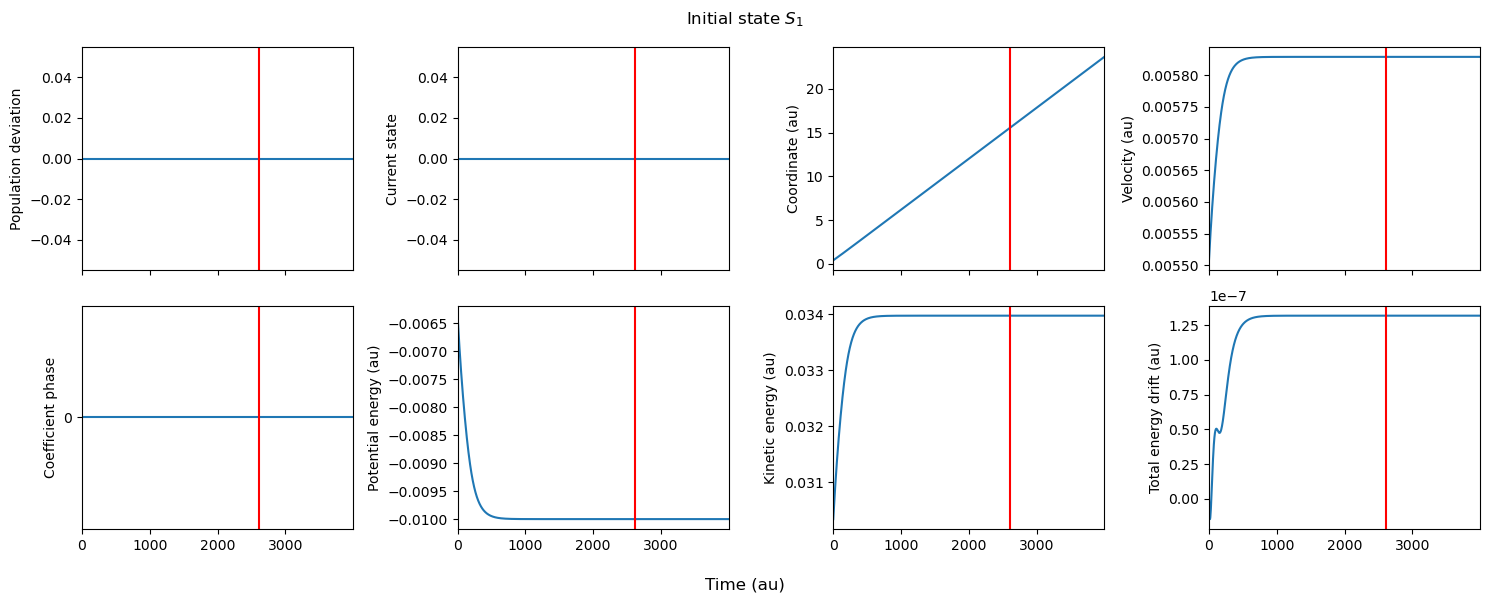

In [46]:
curr_coef = np.take_along_axis(
    np.array(coef_log), np.array(states_log).reshape(-1, 1), axis=1
)
time = np.array(range(len(coef_log))) * dt

fig, ax = plt.subplots(2, 4, figsize=(15, 6), sharex=True, tight_layout=True)
axs = ax.flatten()
fig.supxlabel("Time (au)")
for _ in axs:
    _.set_xlim([0, time[-1]])
axs[0].set_ylabel("Population deviation")
axs[0].plot(time, pop.sum(axis=1) - 1)
axs[1].set_ylabel("Current state")
axs[1].plot(time, states_log)
axs[2].set_ylabel("Coordinate (au)")
axs[2].plot(time, coords_log)
axs[3].set_ylabel("Velocity (au)")
axs[3].plot(time, veloc_log)
axs[4].set_ylabel("Coefficient phase")
axs[4].set_yticks(np.arange(0, np.pi + 0.1, np.pi / 4), [0, "$\pi/4$", "$\pi/2$", "$3\pi/4$", "$\pi$"])
axs[4].plot(time, np.arccos(np.real(curr_coef)))
axs[5].set_ylabel("Potential energy (au)")
axs[5].plot(time, pot_log)
axs[6].set_ylabel("Kinetic energy (au)")
axs[6].plot(time, ekin_log)
axs[7].set_ylabel("Total energy drift (au)")
axs[7].plot(time, ener_log - ener_log[0])
for a in axs:
    a.axvline(time[653], c='r')
fig.suptitle("Initial state $S_1$")

In [8]:
model_xyz = "H 0.5 0 0"
mass = 2000
sigma = 1 / np.sqrt(mass * 3.157746e5 / 300)
nsteps = 500
ntraj = 500
pop_classical = np.zeros((nsteps + 1, 2))
pop_classical[0, 1] = ntraj
pop_quantum = np.zeros((nsteps + 1, 2))
pop_quantum[0, 1] = ntraj


for k in range(ntraj):
    mol = [build_molecules(model_xyz, sample_veloc=True, sigma=sigma, charge=1, nstates=2)]
    mol[0].mass[0] = mass
    mol[0].veloc[0] = 30 / mass
    mol[0].coords[0] = -9
    model = TullyModel1(molecule=mol)
    dt = 4
    sh = SH(mol, 0, [1, 0], model, dt=dt)
    sh.qm.get_H(mol[0].coords)
    sh.qm.diag()
    sh.qm.calculate_forces()
    sh.qm.get_energies()
    for i in range(len(sh.mol)):
        mol = sh.mol[i]
        for j in range(len(mol.states)):
            mol.states[j].energy = model.mol[i].states[j].energy

    coef_log = []
    ham_log = []
    states_log = []
    coords_log = []
    veloc_log = []
    ekin_log = []
    ener_log = []
    pot_log = []

    print(f"trajectory {k}")
    for cstep in range(nsteps):
        # if cstep % 100 == 0:
        #     print("step ", cstep)
        sh.next_velocity()
        sh.next_position()
        for i in range(len(sh.mol)):
            model.mol[i].coords = sh.mol[i].coords
        coords_log.append(sh.mol[0].coords[0, 0])

        model.get_H(sh.mol[i].coords)
        model.diag()
        model.calculate_forces()
        # TODO: wrap this into a function
        for i in range(len(sh.mol)):
            mol = sh.mol[i]
            for j in range(len(mol.states)):
                mol.forces = model.mol[i].states[j].forces
        sh.next_velocity()
        veloc_log.append(sh.mol[0].veloc[0, 0])

        if sh.thermo != None:
            sh.thermo.run(sh)

        # temp = sh.temperature()
        # print("temperature", temp)
        # model.update_potential()
        # TODO: wrap this into a function
        for i in range(len(sh.mol)):
            mol = sh.mol[i]
            for j in range(len(mol.states)):
                mol.states[j].energy = model.mol[i].states[j].energy
        # sh.update_energy()
        ener_log.append(sh.mol[0].etot)
        pot_log.append(sh.mol[0].epot)
        ekin_log.append(sh.mol[0].ekin)

        # print("total energy", sh.mol.etot)

        # if (cstep + 1) % sh.out_freq == 0:
        #     sh.write_md_output(md_dir, cstep)
        #     sh.print_step(cstep)
        # if cstep == sh.nsteps - 1:
        #     sh.write_final_xyz(md_dir, cstep)
        sh.electronic_propagator()
        # print("Coefficient", sh.coef)
        # print("Total population", np.linalg.norm(sh.coef))

        sh.qstep = cstep
        coef_log.append(sh.coef)
        ham_log.append(sh.curr_ham)
        states_log.append(sh.current_states)
    pop = np.abs(coef_log) ** 2
    tmp = np.take_along_axis(pop_classical[1:], np.array(states_log).reshape(-1, 1), axis=1) + 1
    np.put_along_axis(pop_classical[1:], np.array(states_log).reshape(-1, 1), tmp, axis=1)
    pop_quantum[1:] += pop
    write_outputs(k)
pop_classical /= ntraj
pop_quantum /= ntraj

using pyscf Mole.build()!
no. of atoms is 1
trajectory 0
possible hop here [0.         0.06074827] 1
possible hop here [0.00417812 0.        ] 0
possible hop here [0.         0.55966104] 1
possible hop here [0.16851612 0.        ] 0
possible hop here [0.         0.17751898] 1
using pyscf Mole.build()!
no. of atoms is 1
trajectory 1
possible hop here [0.         0.02095056] 1
possible hop here [0.01275632 0.        ] 0
possible hop here [0.         0.64957533] 1
possible hop here [0.24067577 0.        ] 0
using pyscf Mole.build()!
no. of atoms is 1
trajectory 2
possible hop here [0.         0.32162149] 1
possible hop here [0.35837169 0.        ] 0
possible hop here [0.         0.04910354] 1
possible hop here [0.16799937 0.        ] 0
using pyscf Mole.build()!
no. of atoms is 1
trajectory 3
possible hop here [0.         0.42169082] 1
possible hop here [0.27052326 0.        ] 0
possible hop here [0.         0.13557145] 1
possible hop here [0.11837511 0.        ] 0
possible hop here [0.   

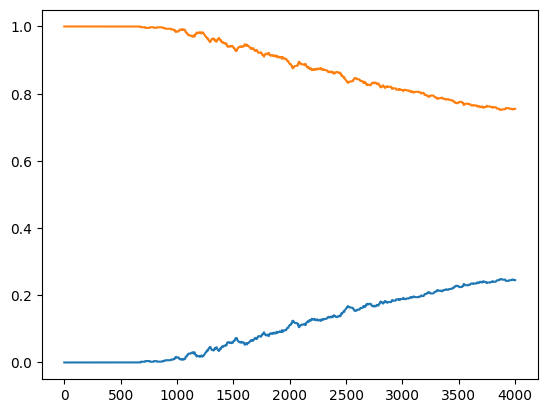

In [8]:
pop_quantum[0] = [0, 1]
pop_classical[0] = [0, 1]
time = np.arange(nsteps + 1) * dt
plt.plot(time, pop_quantum)

Text(0.5, 0.98, 'Initial state $S_1$')

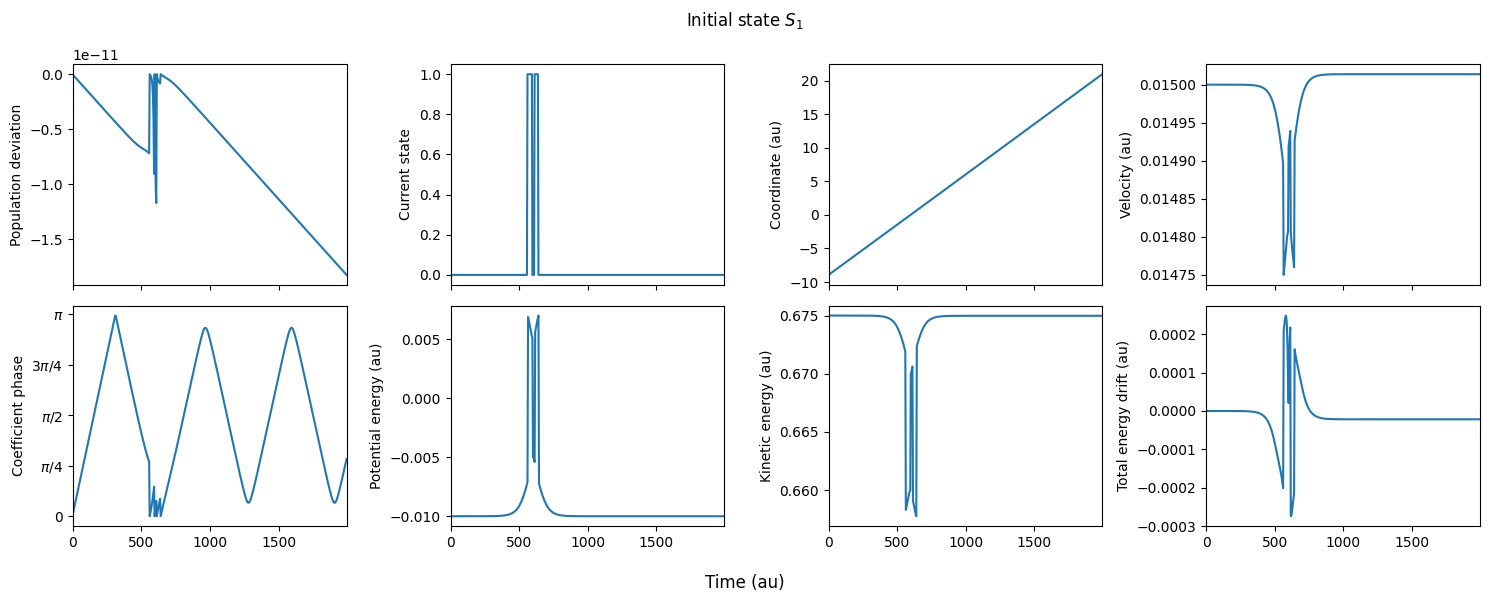

In [11]:
curr_coef = np.take_along_axis(
    np.array(coef_log), np.array(states_log).reshape(-1, 1), axis=1
)
time = np.array(range(len(coef_log))) * dt

fig, ax = plt.subplots(2, 4, figsize=(15, 6), sharex=True, tight_layout=True)
axs = ax.flatten()
fig.supxlabel("Time (au)")
for _ in axs:
    _.set_xlim([0, time[-1]])
axs[0].set_ylabel("Population deviation")
axs[0].plot(time, pop.sum(axis=1) - 1)
axs[1].set_ylabel("Current state")
axs[1].plot(time, states_log)
axs[2].set_ylabel("Coordinate (au)")
axs[2].plot(time, coords_log)
axs[3].set_ylabel("Velocity (au)")
axs[3].plot(time, veloc_log)
axs[4].set_ylabel("Coefficient phase")
axs[4].set_yticks(np.arange(0, np.pi + 0.1, np.pi / 4), [0, "$\pi/4$", "$\pi/2$", "$3\pi/4$", "$\pi$"])
axs[4].plot(time, np.arccos(np.real(curr_coef)))
axs[5].set_ylabel("Potential energy (au)")
axs[5].plot(time, pot_log)
axs[6].set_ylabel("Kinetic energy (au)")
axs[6].plot(time, ekin_log)
axs[7].set_ylabel("Total energy drift (au)")
axs[7].plot(time, ener_log - ener_log[0])
fig.suptitle("Initial state $S_1$")

using pyscf Mole.build()!
no. of atoms is 1
step  0
sh [[[1.88972277 0.         0.        ]]]
md [[1.88972277 0.         0.        ]]
sh [[[1.88971271 0.         0.        ]]]
md [[1.88971271 0.         0.        ]]
sh [[[1.88969594 0.         0.        ]]]
md [[1.88969594 0.         0.        ]]
sh [[[1.88967247 0.         0.        ]]]
md [[1.88967247 0.         0.        ]]
sh [[[1.88964229 0.         0.        ]]]
md [[1.88964229 0.         0.        ]]
sh [[[1.8896054 0.        0.       ]]]
md [[1.8896054 0.        0.       ]]
sh [[[1.8895618 0.        0.       ]]]
md [[1.8895618 0.        0.       ]]
sh [[[1.88951149 0.         0.        ]]]
md [[1.88951149 0.         0.        ]]
sh [[[1.88945448 0.         0.        ]]]
md [[1.88945448 0.         0.        ]]
sh [[[1.88939075 0.         0.        ]]]
md [[1.88939075 0.         0.        ]]
sh [[[1.88932031 0.         0.        ]]]
md [[1.88932031 0.         0.        ]]
sh [[[1.88924317 0.         0.        ]]]
md [[1.88924317 

Text(0.5, 0.98, 'Initial state $S_1$')

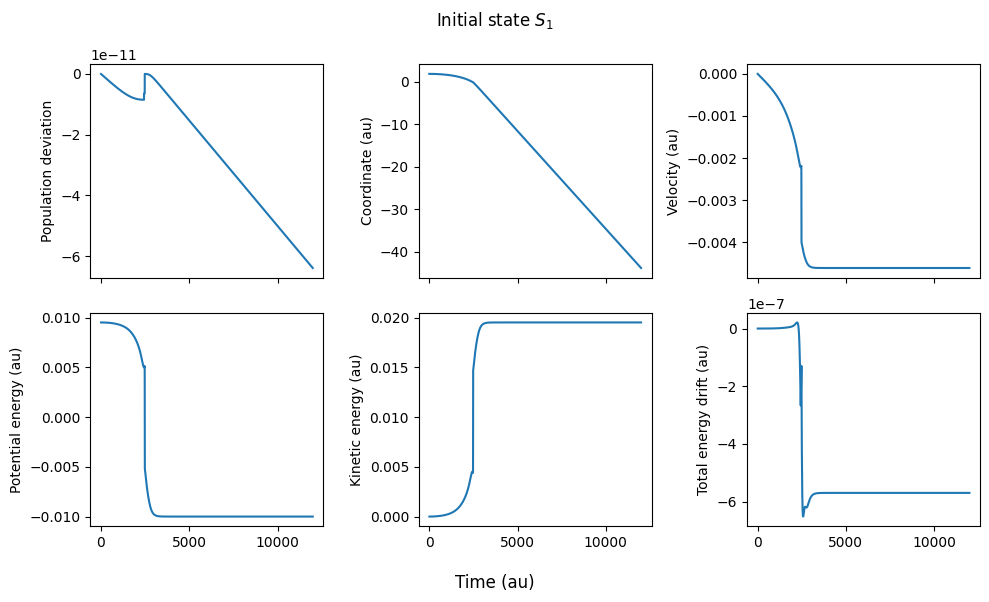

In [43]:
model_xyz ="H 1 0 0"
mol = [build_molecules(model_xyz, charge=1, nstates=2)]
model = TullyModel1(molecule=mol)
dt = 4
sh = SH(mol, 1, [0, 1], model, dt=dt)
model.get_H(mol[0].coords)
model.diag()
model.calculate_forces()

coef_log = []
ham_log = []
states_log = []
coords_log = []
veloc_log = []
ekin_log = []
ener_log = []
pot_log = []

# print(sh.coef)
for cstep in range(3000):
    if cstep % 100 == 0:
        print("step ", cstep)
    sh.next_velocity()
    sh.next_position()
    sh.electronic_propagator()
    for i in range(len(sh.mol)):
        model.mol[i].coords = sh.mol[i].coords
        # print('veloc ipynb', sh.mol[i].veloc)
        print('md', sh.mol[i].coords)
    coords_log.append(sh.mol[0].coords[0, 0])

    model.get_H(sh.mol[i].coords)
    model.diag()
    model.calculate_forces()
    # TODO: wrap this into a function
    for i in range(len(sh.mol)):
        mol = sh.mol[i]
        for j in range(len(mol.states)):
            mol.forces = model.mol[i].states[j].forces
    sh.next_velocity()
    sh.check_hops()
    veloc_log.append(sh.mol[0].veloc[0, 0])

    if sh.thermo != None:
        sh.thermo.run(sh)

    # temp = sh.temperature()
    # print("temperature", temp)
    # model.update_potential()
    # TODO: wrap this into a function
    # for i in range(len(sh.mol)):
    #     mol = sh.mol[i]
    #     for j in range(len(mol.states)):
    #         mol.states[j].energy = model.mol[i].states[j].energy
    # sh.update_energy()
    ener_log.append(sh.mol[0].etot)
    pot_log.append(sh.mol[0].epot)
    ekin_log.append(sh.mol[0].ekin)

    # print("total energy", sh.mol.etot)

    # if (cstep + 1) % sh.out_freq == 0:
    #     sh.write_md_output(md_dir, cstep)
    #     sh.print_step(cstep)
    # if cstep == sh.nsteps - 1:
    #     sh.write_final_xyz(md_dir, cstep)
    # print("Coefficient", sh.coef)
    # print("Total population", np.linalg.norm(sh.coef))

    sh.qstep = cstep
    coef_log.append(sh.coef)
    ham_log.append(sh.curr_ham)
    states_log.append(sh.current_states)

time = np.array(range(len(coef_log))) * dt
fig, ax = plt.subplots(2, 3, figsize=(10, 6), sharex=True, tight_layout=True)
axs = ax.flatten()
fig.supxlabel("Time (au)")
axs[0].set_ylabel("Population deviation")
axs[0].plot(time, np.linalg.norm(coef_log, axis=1) - 1)
axs[1].set_ylabel("Coordinate (au)")
axs[1].plot(time, coords_log)
axs[2].set_ylabel("Velocity (au)")
axs[2].plot(time, veloc_log)
axs[3].set_ylabel("Potential energy (au)")
axs[3].plot(time[1:], pot_log[1:])
axs[4].set_ylabel("Kinetic energy (au)")
axs[4].plot(time[1:], ekin_log[1:])
axs[5].set_ylabel("Total energy drift (au)")
axs[5].plot(time[1:], ener_log[1:] - ener_log[1])
fig.suptitle("Initial state $S_1$")

Text(0.5, 1.0, 'Adiabatic $S_1$ (NACT off)')

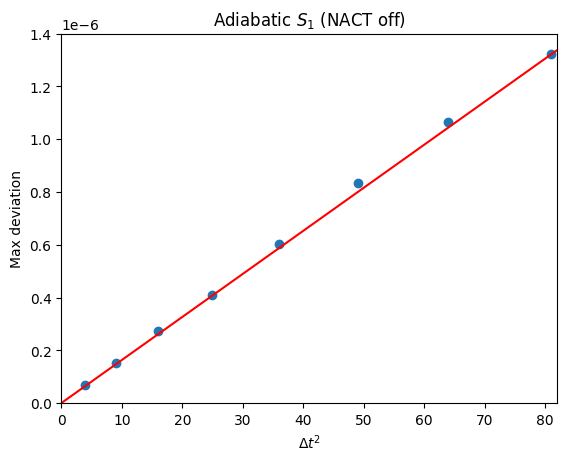

In [37]:
k = errors[-1] / 81
tmp = np.linspace(0, 82, 1000)
plt.xlim([0, 82])
plt.ylim([0, 1.4e-6])
plt.plot(tmp, k * tmp, c='r')
plt.scatter(np.arange(2, 10)**2, errors)
plt.xlabel("$\Delta t^2$")
plt.ylabel("Max deviation")
plt.title("Adiabatic $S_1$ (NACT off)")

Text(0, 0.5, 'Total energy drift (a.u.)')

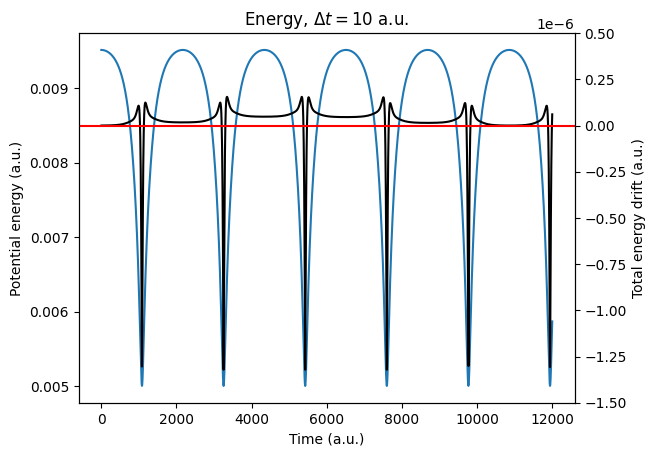

In [31]:
fig, ax = plt.subplots()
ax.set_title("Energy, $\Delta t = 10$ a.u.")
ax.plot(time, pot_log)
ax.set_ylabel("Potential energy (a.u.)")
ax.set_xlabel("Time (a.u.)")
ax2 = ax.twinx()
ax2.set_ylim([-1.5e-6, 5e-7])
ax2.plot(time[1:], ener_log[1:] - ener_log[1], c='k')
ax2.axhline(0, c='r')
ax2.set_ylabel("Total energy drift (a.u.)")

In [2]:
ref1a = np.genfromtxt("test_tully/model1/tully1a.txt")
ref1b = np.genfromtxt("test_tully/tully1b.txt")
ref1c = np.genfromtxt("test_tully/tully1c.txt")

In [3]:
with open("test_tully/model1/summary_lz1.json", "r") as f:
    results = json.load(f)

momenta = [float(_) for _ in results.keys()]
sides = []
for v in results.values():
    sides.append(v["side"])
sides = np.array(sides).reshape(-1, 4)

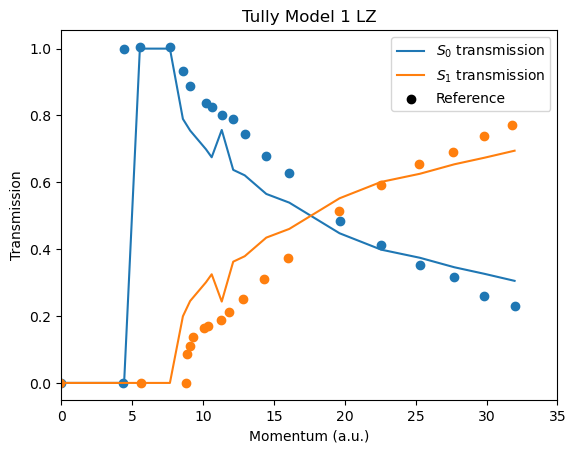

In [4]:
plt.plot(momenta, sides[:, 1], label="$S_0$ transmission")
plt.plot(momenta, sides[:, 3], label="$S_1$ transmission")
plt.scatter(ref1a[:, 0], ref1a[:, 1])
plt.scatter(ref1c[:, 0], ref1c[:, 1])
plt.scatter([], [], c="k", label="Reference")
plt.xlim([0, 1])
plt.xlim([0, 35])
plt.ylabel("Transmission")
plt.xlabel("Momentum (a.u.)")
plt.title("Tully Model 1 LZ")
plt.legend()

In [56]:
with open("test_tully/summary.json", "r") as f:
    results = json.load(f)

momenta = [float(_) for _ in results.keys()]
sides = []
for v in results.values():
    sides.append(v["side"])
sides = np.array(sides).reshape(-1, 4)

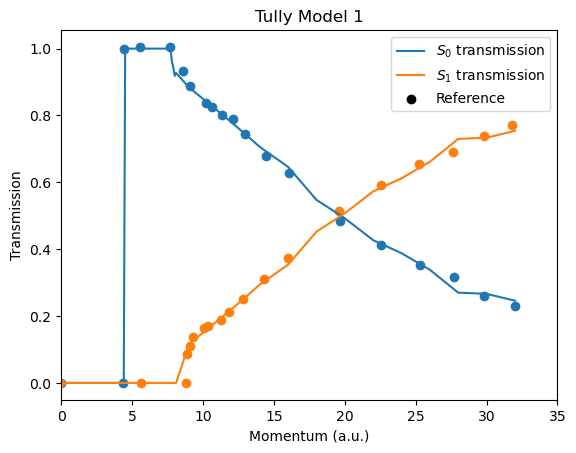

In [57]:
plt.plot(momenta, sides[:, 1], label="$S_0$ transmission")
plt.plot(momenta, sides[:, 3], label="$S_1$ transmission")
plt.scatter(ref1a[:, 0], ref1a[:, 1])
plt.scatter(ref1c[:, 0], ref1c[:, 1])
plt.scatter([], [], c="k", label="Reference")
plt.xlim([0, 1])
plt.xlim([0, 35])
plt.ylabel("Transmission")
plt.xlabel("Momentum (a.u.)")
plt.title("Tully Model 1")
plt.legend()

In [2]:
with open("test_tully/model2/summary_LZ1.json", "r") as f:
    results = json.load(f)

momenta = [float(_) for _ in results.keys()]
sides = []
for v in results.values():
    sides.append(v["side"])
sides = np.array(sides).reshape(-1, 4)

In [3]:
ref2a = np.genfromtxt("test_tully/tully2a.txt")
ref2c = np.genfromtxt("test_tully/tully2c.txt")

In [4]:
lz_ref = np.genfromtxt("test_tully/model2/lz_ref.txt")
lz_ref[:, 0] = np.log(lz_ref[:, 0]**2 / 4000)

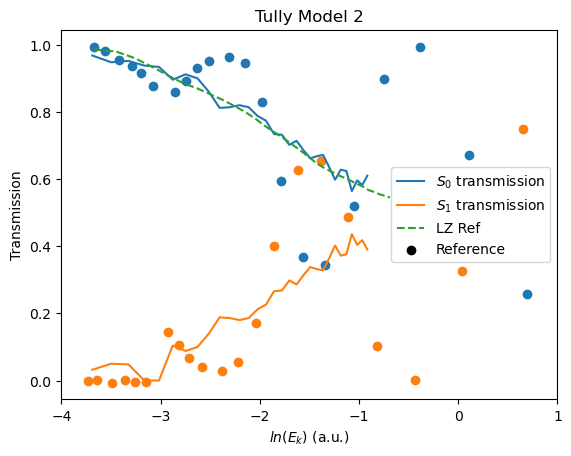

In [5]:
plt.plot(np.log(momenta), sides[:, 1], label="$S_0$ transmission")
plt.plot(np.log(momenta), sides[:, 3], label="$S_1$ transmission")
plt.scatter(ref2a[:, 0], ref2a[:, 1])
plt.scatter(ref2c[:, 0], ref2c[:, 1])
plt.plot(lz_ref[:, 0], lz_ref[:, 1], ls="--", label="LZ Ref")
plt.scatter([], [], c="k", label="Reference")
plt.xlim([0, 1])
plt.xlim([-4, 1])
plt.ylabel("Transmission")
plt.xlabel("$ln (E_k)$ (a.u.)")
plt.title("Tully Model 2")
plt.legend()

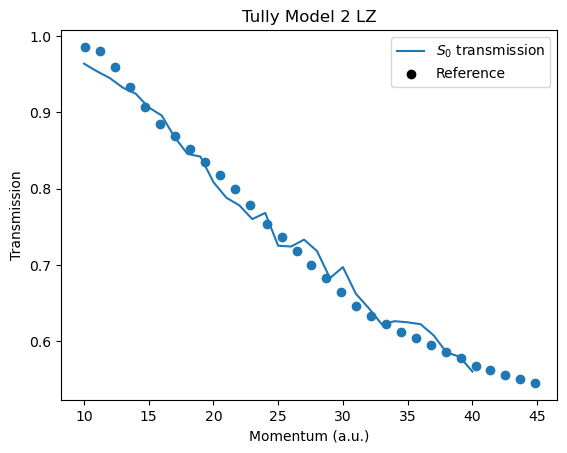

In [29]:
lz_ref = np.genfromtxt("test_tully/model2/lz_ref.txt")
plt.plot(np.arange(10, 41, 1), sides[:, 1], label="$S_0$ transmission")
plt.scatter(lz_ref[:, 0], lz_ref[:, 1])
plt.scatter([], [], c="k", label="Reference")
plt.ylabel("Transmission")
plt.xlabel("Momentum (a.u.)")
plt.title("Tully Model 2 LZ")
plt.legend()

In [11]:
mudslide_results = {
    "4.3": [
        0.0845,
        0.873,
        0.0425,
        0.0
    ],
    "4.3999999999999995": [
        0.093,
        0.8795,
        0.0275,
        0.0
    ],
    "4.499999999999999": [
        0.1035,
        0.8695,
        0.027,
        0.0
    ],
    "4.599999999999999": [
        0.0995,
        0.8735,
        0.027,
        0.0
    ],
    "4.699999999999998": [
        0.096,
        0.859,
        0.045,
        0.0
    ],
    "6.0": [
        0.112,
        0.8155,
        0.0725,
        0.0
    ],
    "7.7": [
        0.0845,
        0.754,
        0.1615,
        0.0
    ],
    "7.8": [
        0.09,
        0.74,
        0.17,
        0.0
    ],
    "7.8999999999999995": [
        0.08,
        0.7495,
        0.1705,
        0.0
    ],
    "7.999999999999999": [
        0.0875,
        0.738,
        0.1745,
        0.0
    ],
    "8.099999999999998": [
        0.0965,
        0.7435,
        0.16,
        0.0
    ],
    "9.0": [
        0.1085,
        0.7185,
        0.173,
        0.0
    ],
    "10.0": [
        0.126,
        0.6935,
        0.1805,
        0.0
    ],
    "12.0": [
        0.1235,
        0.6535,
        0.223,
        0.0
    ],
    "14.0": [
        0.1295,
        0.6355,
        0.235,
        0.0
    ],
    "16.0": [
        0.1335,
        0.621,
        0.2455,
        0.0
    ],
    "18.0": [
        0.1415,
        0.5955,
        0.263,
        0.0
    ],
    "20.0": [
        0.1385,
        0.5835,
        0.278,
        0.0
    ],
    "22.0": [
        0.1505,
        0.597,
        0.2525,
        0.0
    ],
    "24.0": [
        0.148,
        0.573,
        0.279,
        0.0
    ],
    "26.0": [
        0.143,
        0.557,
        0.282,
        0.018
    ],
    "28.0": [
        0.0855,
        0.559,
        0.16,
        0.1955
    ],
    "30.0": [
        0.022,
        0.555,
        0.0385,
        0.3845
    ],
    "32.0": [
        0.002,
        0.5375,
        0.002,
        0.4585
    ]
}
mudslide_results = np.array([_ for _ in mudslide_results.values()])

In [5]:
with open("test_tully/model3_normal/summary.json", "r") as f:
    results = json.load(f)

momenta = [float(_) for _ in results.keys()]
sides = []
for v in results.values():
    sides.append(v["side"])
sides = np.array(sides).reshape(-1, 4)

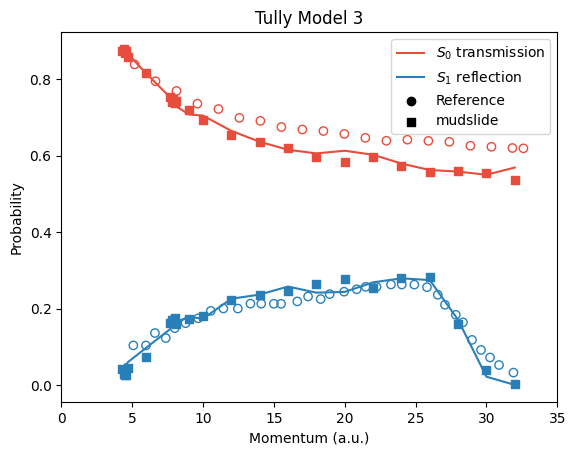

In [35]:
colors = ["#e74c3c", "#f39c12", "#2980b9"]
ref3a = np.genfromtxt("test_tully/tully3a.txt")
ref3c = np.genfromtxt("test_tully/tully3c_dash.txt")
plt.plot(momenta, sides[:, 1], c=colors[0], label="$S_0$ transmission")
plt.plot(momenta, sides[:, 2], c=colors[2], label="$S_1$ reflection")
plt.scatter(ref3a[:, 0], ref3a[:, 1], edgecolors=colors[0], facecolors="none")
plt.scatter(ref3c[:, 0], ref3c[:, 1], edgecolors=colors[2], facecolors="none")
plt.scatter(momenta, mudslide_results[:, 1], marker="s", c=colors[0])
plt.scatter(momenta, mudslide_results[:, 2], marker="s", c=colors[2])
plt.scatter([], [], c="k", label="Reference")
plt.scatter([], [], marker="s", c="k", label="mudslide")
plt.xlim([0, 1])
plt.xlim([0, 35])
plt.ylabel("Probability")
plt.xlabel("Momentum (a.u.)")
plt.title("Tully Model 3")
plt.legend()

In [2]:
pop_quantum_ml = np.zeros((1000, 3))
pop_classical_ml = np.zeros((1000, 3))
count = 0
dirs = os.listdir("test_ml/results_s2")
for i in dirs:
    dir = f"test_ml/results_s2/{i}"
    states = np.genfromtxt(f"{dir}/states.txt").astype(int)
    pop = np.genfromtxt(f"{dir}/population.txt")
    total_steps = len(pop)
    if np.sum(pop[-1]) > 0.9:
        count += 1
        tmp = (
            np.take_along_axis(
                pop_classical_ml[:total_steps], np.array(states).reshape(-1, 1), axis=1
            )
            + 1
        )
        np.put_along_axis(
            pop_classical_ml[:total_steps], np.array(states).reshape(-1, 1), tmp, axis=1
        )
        pop_quantum_ml[:total_steps] += pop
pop_classical_ml /= count
pop_quantum_ml /= count

In [24]:
pop_quantum_nexmd = np.zeros((101, 3))
pop_classical_nexmd = np.zeros((101, 3))
count = np.zeros(101)
dirs = os.listdir("/projects/ml4chem/xinyang/azomethane/ml/namd_s1")
for i in dirs:
    if "test" in i:
        continue
    dir = f"/projects/ml4chem/xinyang/azomethane/ml/namd_s1/{i}"
    if not os.path.isdir(dir):
        continue
    coeff = np.genfromtxt(f"{dir}/coeff-n.out")
    states = coeff[:, 0].astype(int) - 1
    pop = coeff[:, 2:5]
    total_steps = len(pop)
    count[:total_steps] += 1
    tmp = (
        np.take_along_axis(
            pop_classical_nexmd[:total_steps], np.array(states).reshape(-1, 1), axis=1
        )
        + 1
    )
    np.put_along_axis(
        pop_classical_nexmd[:total_steps], np.array(states).reshape(-1, 1), tmp, axis=1
    )
    pop_quantum_nexmd[:total_steps] += pop
count = count.reshape(-1, 1)
pop_classical_nexmd /= count
pop_quantum_nexmd /= count

In [27]:
%config InlineBackend.figure_formats = ['svg']

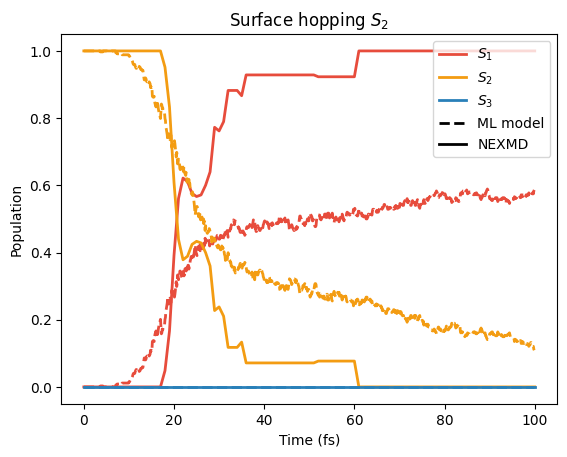

In [4]:
time = np.arange(0, 100, 0.1)
time_nexmd = np.arange(0, 101, 1.0)
colors = ["#e74c3c", "#f39c12", "#2980b9"]
for i in range(3):
    plt.plot(time_nexmd, pop_classical_nexmd[:, i], c=colors[i], label=f"$S_{i + 1}$", lw=2)
    plt.plot(time, pop_classical_ml[:, i], c=colors[i], ls="--", lw=2)
plt.plot([], [], c="k", ls="--", lw=2, label="ML model")
plt.plot([], [], c="k", lw=2, label="NEXMD")
plt.title("Surface hopping $S_2$")
plt.ylabel("Population")
plt.xlabel("Time (fs)")
plt.legend()
plt.savefig("output.svg", transparent=True)

In [31]:
# azomethane
xyz="""N  0.4760177638  -0.0475940764  -0.4375424021
     N  -0.4364578671  -0.1642356340  0.4086339167
     C  1.8187745667  0.1041611975  0.0581195280
     C  -1.8498794909  0.0803062997  -0.0363125589
     H  1.8315794965  0.4840772946  1.1376072336
     H  2.3027755454  0.8024813467  -0.6161179440
     H  2.2893537170  -0.8861399303  -0.1261898714
     H  -1.9947885178  0.8200091191  -0.8472666130
     H  -2.3527667843  0.4180205764  0.9247652133
     H  -2.2493589642  -0.8994973379  -0.3282275292"""

In [32]:
veloc="""-0.4674400649    -1.0169339146    -1.2515848404
    -4.5802695645    -6.1117892101    -2.3723870239
     0.3804410260     3.1171174706     0.3856583457
    -0.8134410199     4.8885310064     2.1782025131
    -8.2457995938    19.3517455081    -3.4412219012
    12.6343881001    -7.1174829676    -8.2430458898
    16.4085815154    -0.7456967398    13.9815710165
    29.9130482951    -7.7238001396    30.2826658291
    13.1669746917    15.5454290290    -0.4174714459
    12.0268386979   -15.6140137393   -12.1960564813"""
veloc = np.array(veloc.split(), dtype=float).reshape(-1, 3) * A2au / fs2au / 1000

In [38]:
# trajectory taken from /projects/ml4chem/xinyang/azomethane/ml/bomd_s2/7520
xyz = """N  0.4510539073  0.2819140372  -0.3265220727
     N  -0.4422069697  -0.3284274555  0.2246181478
     C  1.8310281758  0.0518381440  0.0321861288
     C  -1.8303581429  -0.0399140770  0.0556092137
     H  2.1618227959  -0.8845481918  -0.4940810058
     H  1.9988787521  0.0074489025  1.1162364759
     H  2.4029900549  0.8707336114  -0.5216418076
     H  -2.0537011535  0.9911549930  -0.4111086677
     H  -2.2848372654  -0.1404426826  1.1142838131
     H  -2.3027538483  -0.8530699287  -0.5390258075"""
veloc = """-1.0051830544     4.7237532296     8.1514131295
    -0.4810829723    -5.8803041478    -4.5214294804
     1.2156820712    -1.0031132209    -3.7910132419
     0.4115438964     4.6371909403    -2.1871828181
    16.4340070438   -26.1365571759    19.2567674439
   -21.7786985133    29.4525856596   -24.1770348763
   -10.8219836994    -5.4896641967     6.6638899192
     4.2697814801   -22.6784903869   -15.7717243249
    22.4895607656   -16.0681027196     0.8823139464
    -9.3191499372    13.4711300432    34.1047197957"""
veloc = np.array(veloc.split(), dtype=float).reshape(-1, 3) * A2au / fs2au / 1000

In [4]:
def dihedral(coords, a, b, c, d):
    ab = coords[b] - coords[a]
    bc = coords[c] - coords[b]
    cd = coords[d] - coords[c]
    normal_abc = np.cross(ab, bc)
    normal_bcd = np.cross(bc, cd)
    angle = np.arccos(
        np.dot(normal_abc, normal_bcd)
        / np.linalg.norm(normal_abc)
        / np.linalg.norm(normal_bcd)
    )
    return angle / np.pi * 180

In [5]:
def build_molecules(xyz: Union[str, List[str]], sample_veloc=False, sigma=None, **kwargs):
    if isinstance(xyz, str):
        test_molecules = Molecule(atom=xyz, **kwargs)
        # generate random velocities
        if sample_veloc:
            v = np.random.randn(*test_molecules.veloc.shape) * sigma
            test_molecules.veloc = v
    else:
        test_molecules = []
        for _ in xyz:
            mol = Molecule(atom=_, **kwargs)
            if sample_veloc:
                v = np.random.randn(*mol.veloc.shape) * sigma
                mol.veloc = v
            test_molecules.append(mol)
    return test_molecules

In [7]:
"""
basic MQC module
"""

import datetime
import math
import os
import shutil
import textwrap
from copy import copy
from typing import List, Union

import numpy as np
import torch

# This should be equivalent to the APC subroutine in NEXMD
# TODO: implement one version ourselves?
from scipy.optimize import linear_sum_assignment

import openms
from openms.lib.misc import Molecule, au2A, call_name, fs2au, typewriter
from openms.qmd.es_driver import QuantumDriver
from openms.qmd.propagator import rk45

from openms.qmd.mqc import MQC

# TODO: this kind of definition should be part of backend
ArrayLike = Union[np.ndarray, torch.Tensor]


class SHH(MQC):
    """Class for nuclear/electronic propagator used in surface hopping dynamics

    Attributes:
       :param object molecule: Molecule object

    """

    def __init__(
        self,
        molecule: List[Molecule],
        init_states: int,
        init_coef: np.array,
        qm: QuantumDriver,
        thermostat=None,
        decoherence=True,
        frustrated_hop=True,
        **kwargs,
    ):
        """Surface hopping

        :param molecule: list of molecular objects
        :type molecule: List[Molecule]
        :param init_states: initial states of each molecule
        :type init_states: np.array
        :param init_coef: initial wavefunction coefficients of each molecule
        :type init_coef: np.array
        :param qm: electronic structure driver
        :type qm: QuantumDriver
        :param thermostat: thermostat, defaults to None
        :type thermostat: object, optional
        """
        # Initialize input values
        super().__init__(molecule, init_states, init_coef, qm, thermostat, **kwargs)
        self.__dict__.update(kwargs)
        self.md_type = self.__class__.__name__
        # self.curr_ham = np.empty((len(self.mol), self.nstates, self.nstates))
        # a quick and dirty way to find the number of states
        if len(init_coef) > 30:
            self.find_hop = self._find_hop_numpy
        else:
            self.find_hop = self._find_hop_loop
        self.decoherence = decoherence
        self.frustrated_hop = frustrated_hop
        self.first_state = 1
        self.curr_coords = np.array([])
        self.curr_veloc = np.array([])
        self.sync_variables("coords")
        self.sync_variables("veloc")
        self.curr_ham = np.empty(
            (self.nstates - self.first_state, self.nstates - self.first_state),
            dtype=complex,
        )
        self.curr_time: float
        self.saved_coords: ArrayLike
        self.probability: ArrayLike

    def initialize(self, *args):
        r"""Prepare the initial conditions for both quantum and classical EOM
        It should be implemented in derived class!
        """
        # call the BaseMD.initialize for the nuclear part.
        base_dir, md_dir, qm_log_dir = super().initialize(*args)

        # initialization for electronic part (TBD)
        return base_dir, md_dir, qm_log_dir
        # return NotImplementedError("Method not implemented!")

    def sync_variables(self, var_name, forward=True):
        current = f"curr_{var_name}"
        # from self.mol[:].var_name to self.curr_{var_name}
        if forward:
            tmp = np.array([getattr(mol, var_name) for mol in self.mol])
            if hasattr(getattr(self, current), "__trunc__"):
                setattr(self, current, tmp[0])
            else:
                setattr(self, current, tmp)
        else:
            tmp = getattr(self, current)
            if hasattr(tmp, "__trunc__"):
                [setattr(mol, var_name, tmp) for mol in self.mol]
            else:
                [setattr(mol, var_name, v) for mol, v in zip(self.mol, tmp)]

    def electronic_propagator(self):
        coef = copy(self.coef)
        p = np.zeros(len(coef))
        # self.sync_variables("coords")
        self.sync_variables("veloc")
        for _ in range(self.nesteps):
            coef = self.quantum_step(self.curr_time, coef)
            density = self.get_densities(coef)
            p = self.hopping_probability(p, density)
            self.curr_time += self.edt
            self.curr_coords = self.saved_coords
        self.sync_variables("coords", forward=False)
        # print("sh", self.curr_coords)
        # e = self.qm.get_energies(self.mol[0].coords)
        # nacr = self.qm.get_nacr()
        # self.check_hops(coef, p, e, nacr)
        self.coef = coef
        self.probability = p
        # assign updated coefficients to each molecule
        # FIXME: this will only work if there is one molecule
        # for i, m in enumerate(self.mol):
        #     m.coef = coef[i]

    def quantum_step(self, t: float, coef: np.array):
        """Propagate one quantum step

        :param t: current time t
        :type t: float
        :param coef: coefficients at current time
        :type coef: np.array
        :return: coefficient at time t + quantum_step
        :rtype: np.array
        """
        return rk45(self.get_coef_dot, t, coef, self.edt)

    def get_coef_dot(self, t: float, coef: np.array):
        """Calculate the acceleration for the coefficient at given Hamiltonian

        :param t: current time
        :type t: float
        :param coef: coefficients at current time
        :type coef: np.array
        :return: time derivative of the coefficients at current time
        :rtype: np.array
        """
        # if saved time is different from given current time
        # the Hamiltonian needs to be recalculated
        # if t != self.curr_time:
        # FIXME: in many molecule case, this will not work.
        # self.curr_coords += self.curr_veloc * self.edt / 2
        # energies = self.qm.get_energies(self.curr_coords)
        # nact = self.qm.get_nact(self.curr_coords)
        # self.curr_ham = self.get_H(energies, nact)
        # self.curr_time = t
        # self.curr_ham = self.get_H(t)
        # coords = self.curr_coords + self.curr_veloc * (t - self.curr_time)
        # FIXME: better way to pass the "temporary" coordinates to qm!
        coords = self.curr_coords.copy()
        self.curr_coords += self.curr_veloc * (t - self.curr_time)
        self.sync_variables("coords", forward=False)
        # coords = self.curr_coords + self.curr_veloc * (t - self.curr_time)
        energies = self.qm.get_energies()[0]
        nact = self.qm.get_nact(self.curr_veloc)
        ham = self.get_H(energies, nact)
        print(ham.shape, coef.shape)
        c_dot = -1j * ham @ coef
        self.saved_coords = self.curr_coords
        self.curr_coords = coords
        return c_dot

    def dump_step(self):
        r"""Output coordinates, velocity, energies, electronic populations, etc.
        Universal properties will be dumped here (velocity, coordinate, energies)
        Other will be dumped in derived class!
        """

        return NotImplementedError("Method not implemented!")

    def get_H(self, energies: np.array, nact: np.array):
        """Function to assemble the Hamiltonian at the current quantum step.
        side.

        :param energies: potential energies of all excited states
        :type E: np.array
        :param nact: non-adiabatic coupling term
        :type nact: np.array
        :return: Hamiltonian of the system in matrix representation
        :rtype: np.array
        """
        ham = np.zeros_like(self.curr_ham)
        nact_cmplx = -1j * nact
        for i in range(self.first_state, len(energies)):
            # counter = 0
            idx = i - self.first_state
            ham[idx, idx] = energies[i]
        # fixme: dirty fix for one molecule only
        ham += nact_cmplx[0]
        self.curr_ham = ham
        return ham

    def get_densities(self, coef: np.array):
        # return np.einsum("i, j -> ij", np.conj(self.coef), self.coef)
        return np.outer(np.conj(coef), coef)

    def hopping_probability(self, p: np.array, density: np.array):
        j = self.current_states - self.first_state
        for n in range(self.nstates - self.first_state):
            if n != j:
                tmp = np.real(1j * density[n, j] * self.curr_ham[j, n])
                tmp *= 2 * self.edt / density[j, j].real
                # TODO: use trapezoid?
                p[n] += tmp
        return p

    def minimum_cost_solver(
        self, trans_den_mat_new: np.array, trans_den_mat_old: np.array
    ):
        """Solver to find the order of states to maximize the trace of the overlap
        matrix.

        :param trans_den_mat_new: transition density matrix at the current step
        :type trans_den_mat_new: np.array
        :param trans_den_mat_old: transition density matrix at the previous step
        :type trans_den_mat_old: np.array
        :return: order of all states at the current step
        :rtype: np.array
        """
        overlap_matrix = np.matmal(trans_den_mat_old, trans_den_mat_new.T)
        nstates = len(overlap_matrix)
        for i in range(nstates):
            for j in range(nstates):
                if j < i - 2 or j > i + 2:
                    overlap_matrix[i, j] = -1e5
        # idx will be the indices that leads to the minium cost
        _, idx = linear_sum_assignment(overlap_matrix, maximize=True)
        return idx, overlap_matrix

    def check_crossing(self, trans_den_mat_new: np.array, trans_den_mat_old: np.array):
        "check overlap for the same states before and after possible crossing"

        order = np.arange(len(trans_den_mat_new))
        cross = np.empty_like(order)
        state_idx_new, overlap = self.minimum_cost_solver(
            trans_den_mat_new, trans_den_mat_old
        )
        for i in range(len(order)):
            j = state_idx_new[i]
            if j != i:
                if i < j:
                    order[[i, j]] = order[[j, i]]
                if i < j or i == self.states:
                    if abs(overlap[i, j]) >= 0.9:
                        # trivial crossing
                        cross[i] = 2
                    else:
                        # reduce time step
                        cross[i] = 1
                else:
                    cross[i] = 0
            else:
                cross[i] = 0
        return order, cross

    def check_hops(self):
        final_state = self.find_hop(self.probability)
        # print(probability, rand)
        # no possible hop is identified
        if final_state > -1:
            final_state += self.first_state
            # print("possible hop here", self.probability, final_state)
            e = self.qm.get_energies()
            self.sync_variables("veloc")
            nacr = self.qm.get_nacr()
            (
                self.current_states,
                self.curr_veloc,
                hop_type,
            ) = self.velocity_rescaling(
                self.current_states, final_state, self.curr_veloc, e, nacr
            )
            self.sync_variables("veloc", forward=False)
            # if hop is successful, exit
            if hop_type == 1:
                # TODO: unify the variable names to use self.sync_variables
                for mol in self.mol:
                    mol.current_state = self.current_states
                # TODO: other decoherence schemes
            if self.decoherence:
                # apply instantaneous decoherence
                self.instantaneous_decoherence(self.current_states)

    def _find_hop_numpy(self, p: ArrayLike):
        """Find possible hop with operations vectorized. When the number of states is
        large (> 50), the function will be faster.

        :param p: array of hop probabilities
        :type p: np.array
        :return: final state index
        :rtype: integer
        """
        rand = self.prng.random()
        p[p < 0] = 0
        # calculate the cumulative sum of the probability array
        p_sum = np.cumsum(p)
        # return the idx if we were to insert `rand` into the array
        idx = np.searchsorted(p_sum, rand)
        # rand > sum(p), no hop
        if idx == len(p):
            return -1
        # if rand is exactly the same as the p_sum[idx], numpy will return idx
        # which is invalid for SH algorithm
        # practically, this will probably never happen
        elif rand == p_sum[idx]:
            return -1
        return idx

    def _find_hop_loop(self, p: ArrayLike):
        """Find possible hop with a loop. When the number of states is small
        (around < 30), the loop approach is likely faster than numpy.

        :param p: array of hop probabilities
        :type p: ArrayLike
        :return: final state index
        :rtype: integer
        """
        # generate random number
        rand = self.prng.random()
        # print(np.sum(p), rand)
        # manually compute cumulative sum
        cumsum = 0
        for idx, prob in enumerate(p):
            if prob <= 0:
                continue
            cumsum += prob
            if cumsum > rand:
                return idx
        return -1

    def velocity_rescaling(
        self,
        state_i: int,
        state_f: int,
        veloc: np.array,
        energies: np.array,
        nacr: np.array,
    ):
        """
        Updates velocity by rescaling the *momentum* in the specified direction and amount

        :param direction: the direction of the *momentum* to rescale
        :param reduction: how much kinetic energy should be damped
        """
        # normalize
        nacr = nacr[0, state_i - self.first_state, state_f - self.first_state]
        nacr = nacr / np.linalg.norm(nacr)
        inverse_mass = 1 / self.mol[0].mass
        a = np.sum(inverse_mass.reshape(-1, 1) * nacr**2)
        energies = energies[0]
        e_i = energies[state_i]
        e_f = energies[state_f]
        dE = e_f - e_i
        b = 2 * np.einsum("ij, ij", nacr, veloc[0])
        c = 2 * dE
        delta = b**2 - 4 * a * c
        # frustrated hops
        if delta < 0:
            if self.frustrated_hop:
                veloc = -veloc
            return state_i, veloc, 2
        # hops allowed
        if b < 0:
            factor = -(b + math.sqrt(delta)) / (2 * a)
        else:
            factor = -(b - math.sqrt(delta)) / (2 * a)
        veloc += factor * inverse_mass.reshape(-1, 1) * nacr
        return state_f, veloc, 1

    def instantaneous_decoherence(self, state):
        self.coef = np.zeros_like(self.coef, dtype=complex)
        self.coef[state - self.first_state] = 1 + 0j

In [8]:
%%prun
mol = [build_molecules(xyz, charge=0, nstates=4)]
mol[0].veloc = veloc.copy()
nn_es = NNDriver(
    mol,
    4,
    "test_ml/nn_models/all_states_30_28_0.7665723566179274_3.4134447177301515_4.6860240434651805_3_3_515",
    # "test_ml/nn_models/s1_new_new_30_28_0.7665723566179274_3.4134447177301515_4.6860240434651805_3_3",
    energy_conversion=1,
)
dt = np.float64(0.1 * fs2au)
sh = SH(mol, 2, np.array([0, 1, 0], dtype=complex), nn_es, nesteps=4, dt=dt)
sh.qm.calculate_forces()
sh.qm.get_energies()
# print(sh.mol[0].states[3].forces / nn_es.energy_conversion * nn_es.coords_conversion)
# sys.exit()
coef_log = []
ham_log = []
states_log = []
coords_log = []
veloc_log = []
ekin_log = []
ener_log = []
pot_log = []

for cstep in range(1000):
    # if cstep % 100 == 0:
    #     print("step ", cstep)
    print("step ", cstep)
    print("population", np.abs(sh.coef) ** 2, np.sum(np.abs(sh.coef) ** 2))
    sh.next_velocity()
    # print(sh.mol[0].coords)
    # sh.next_position()
    sh.electronic_propagator()
    # print("ass", sh.mol[0].coords)
    coords_log.append(sh.mol[0].coords.copy())

    nn_es.calculate_forces()
    nn_es.get_energies()
    sh.next_velocity()
    # sh.check_hops()
    veloc_log.append(sh.mol[0].veloc[0, 0])
    # print(sh.mol[0].states)
    # print("list", veloc_log[-1])
    # print("loop", sh.mol[0].veloc[0])

    if sh.thermo != None:
        sh.thermo.run(sh)

    ener_log.append(sh.mol[0].etot)
    pot_log.append(sh.mol[0].epot)
    ekin_log.append(sh.mol[0].ekin)

    sh.qstep = cstep
    coef_log.append(sh.coef)
    ham_log.append(sh.curr_ham)
    states_log.append(sh.current_states)
    # print(sh.current_states, nn_es.pred["F"], mol[0].coords)
    angle = dihedral(sh.curr_coords[0], 2, 0, 1, 3)
    if np.isnan(angle) or angle < 90:
        break

NameError: name 'xyz' is not defined

Text(0.5, 0.98, 'Initial state $S_3$')

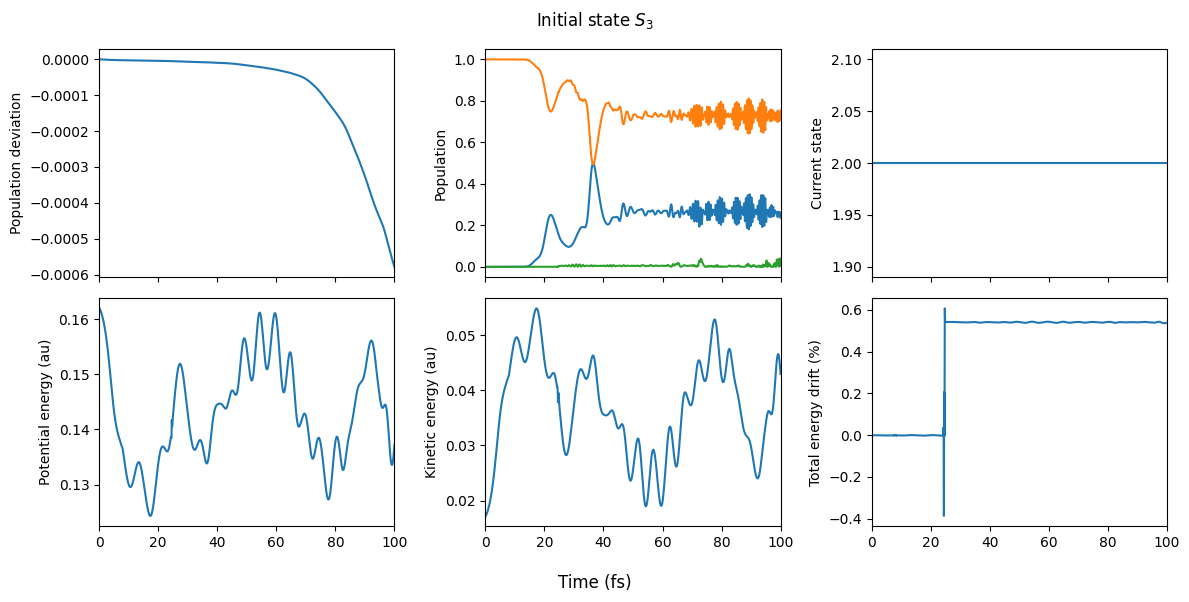

In [40]:
curr_coef = np.take_along_axis(
    np.array(coef_log), np.array(states_log).reshape(-1, 1) - sh.first_state, axis=1
)
pop = np.abs(coef_log) ** 2
time = np.array(range(len(coef_log))) * 0.1 + 0.1

fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, tight_layout=True)
axs = ax.flatten()
fig.supxlabel("Time (fs)")
for _ in axs:
    _.set_xlim([0, time[-1]])
axs[0].set_ylabel("Population deviation")
axs[0].plot(time, pop.sum(axis=1) - 1)
axs[1].set_ylabel("Population")
axs[1].plot(time, pop)
axs[2].set_ylabel("Current state")
axs[2].plot(time, states_log)
axs[3].set_ylabel("Potential energy (au)")
axs[3].plot(time, pot_log)
axs[4].set_ylabel("Kinetic energy (au)")
axs[4].plot(time, ekin_log)
axs[5].set_ylabel("Total energy drift (%)")
# axs[5].set_ylim([-0.0003, 0.0023])
axs[5].plot(time, (ener_log - ener_log[0]) / ener_log[0] * 100)
# axs[7].plot(time, ener_log)
# for a in axs:
#     a.axvline(time[73], c='r')
fig.suptitle("Initial state $S_3$")

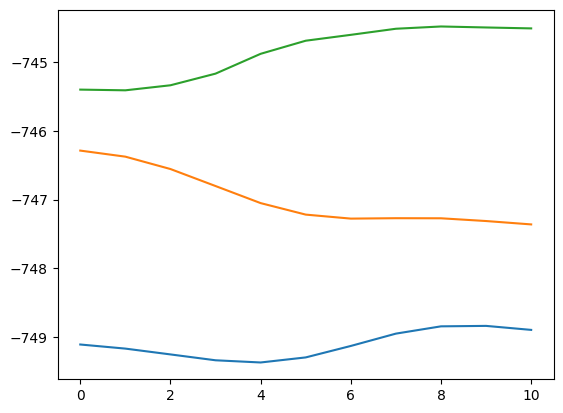

In [35]:
tmp = np.genfromtxt("/projects/ml4chem/xinyang/azomethane/ml/bomd_s2/0020/pes.out")
plt.plot(tmp[:, 0], tmp[:, 2:])

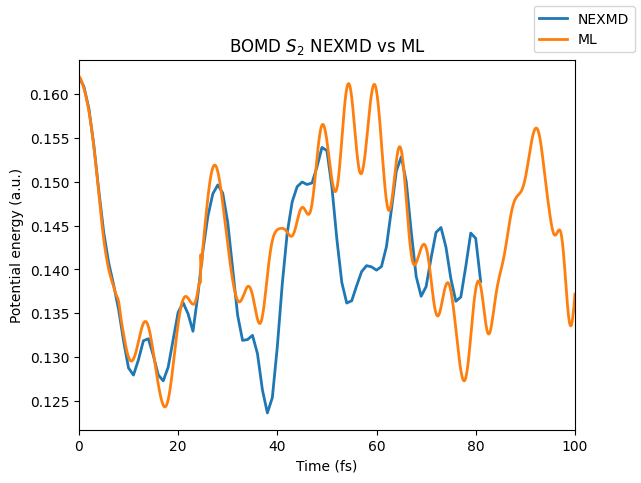

In [43]:
tmp = np.genfromtxt("/projects/ml4chem/xinyang/azomethane/ml/bomd_s2/7520/energy-ev.out")
time_nexmd = tmp[:, 0]
ek_nexmd = tmp[:, 1] * eV2au
pot_nexmd = tmp[:, 3] * eV2au
colors = ["#e74c3c", "#f39c12", "#2980b9"]
fig, ax = plt.subplots()
ax.plot(time_nexmd, pot_nexmd - pot_nexmd[0] + pot_log[0], label=f"NEXMD", lw=2)
ax.plot(time, pot_log, label="ML", lw=2)
ax.set_xlim(0, 100)
plt.title("BOMD $S_2$ NEXMD vs ML")
ax.set_ylabel("Potential energy (a.u.)")
ax.set_xlabel("Time (fs)")
# ax2 = ax.twinx()
# ax2.set_ylabel("Total energy drift (%)")
# ax2.plot(time, (ener_log - ener_log[0]) / ener_log[0] * 100, ls=":", c="k", label="Total energy drift")
fig.legend()

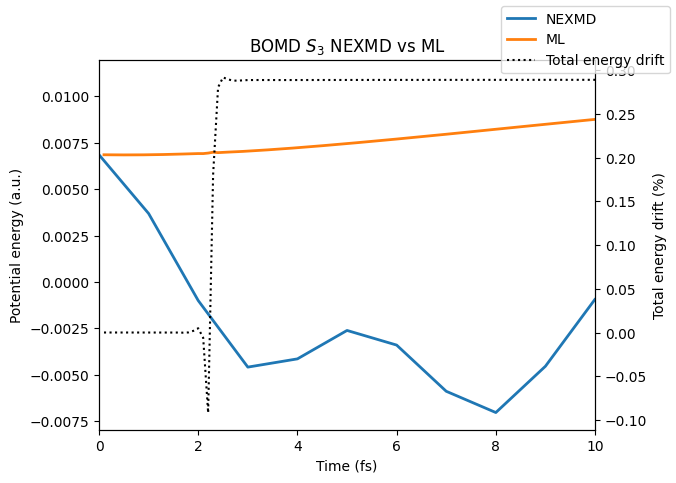

In [13]:
fig, ax = plt.subplots()
ax.plot(time_nexmd, pot_nexmd - pot_nexmd[0] + pot_log[0], label=f"NEXMD", lw=2)
ax.plot(time, pot_log, label="ML", lw=2)
ax.set_xlim(0, 10)
plt.title("BOMD $S_3$ NEXMD vs ML")
ax.set_ylabel("Potential energy (a.u.)")
ax.set_xlabel("Time (fs)")
ax2 = ax.twinx()
ax2.set_ylabel("Total energy drift (%)")
ax2.plot(
    time,
    (ener_log - ener_log[0]) / ener_log[0] * 100,
    ls=":",
    c="k",
    label="Total energy drift",
)
fig.legend()

In [70]:
with open("ml_model.xyz", "w") as f:
    for t, coord in zip(time[9::10], coords_log[9::10]):
        tmp = coord / A2au
        print(f"10\nt = {t} fs", file=f)
        for e, c in zip(sh.mol[0].elements, tmp):
            print(e, c[0], c[1], c[2], file=f)


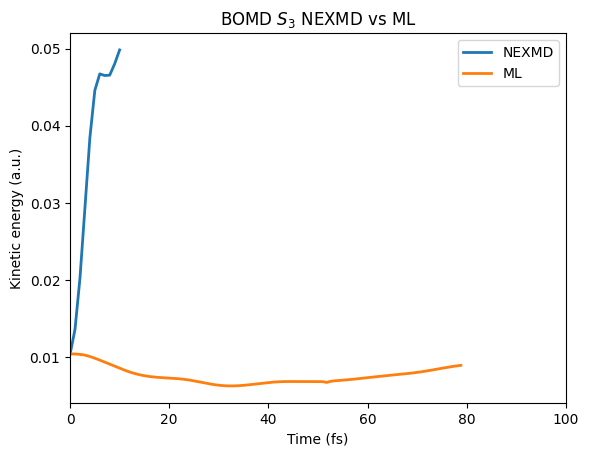

In [29]:
plt.plot(time_nexmd, ek_nexmd, label=f"NEXMD", lw=2)
plt.plot(time, ekin_log, label="ML", lw=2)
plt.xlim(0, 100)
plt.title("BOMD $S_3$ NEXMD vs ML")
plt.ylabel("Kinetic energy (a.u.)")
plt.xlabel("Time (fs)")
plt.legend()

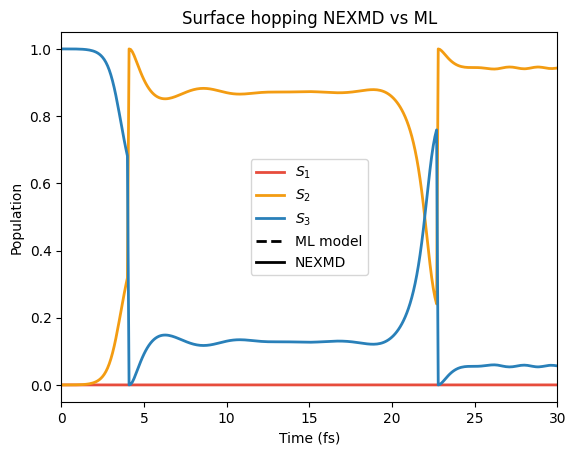

In [8]:
coeff = np.genfromtxt("/projects/ml4chem/xinyang/azomethane/ml/NEXMD1/test/coeff-n.out")
states = coeff[:, 0].astype(int) - 1
time_nexmd = coeff[:, 1]
pop_nexmd = coeff[:, 2:5]
colors = ["#e74c3c", "#f39c12", "#2980b9"]
for i in range(3):
    plt.plot(time_nexmd, pop_nexmd[:, i], c=colors[i], label=f"$S_{i + 1}$", lw=2)
    plt.plot(time, pop[:, i], c=colors[i], ls="--", lw=2)
plt.plot([], [], c="k", ls="--", lw=2, label="ML model")
plt.plot([], [], c="k", lw=2, label="NEXMD")
plt.xlim(0, 30)
plt.title("Surface hopping NEXMD vs ML")
plt.ylabel("Population")
plt.xlabel("Time (fs)")
plt.legend()

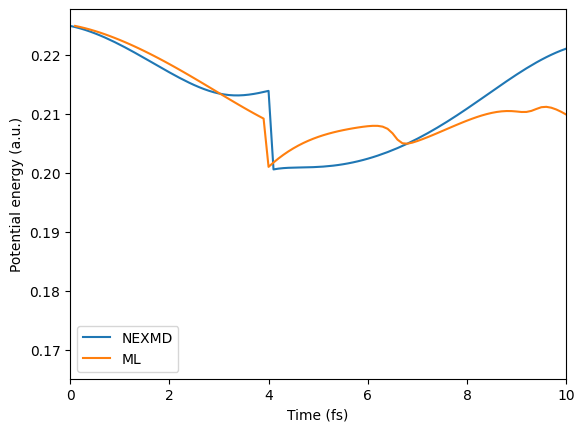

In [19]:
pes = np.genfromtxt(
    "/projects/ml4chem/xinyang/azomethane/ml/NEXMD1/test/pes.out", usecols=(2, 3, 4)
)
plt.xlim([0, 10])
e = np.take_along_axis(pes, states.reshape(-1, 1), axis=1) * eV2au
e -= e[0] - pot_log[0]
plt.plot(time_nexmd, e, label="NEXMD")
plt.plot(time, pot_log, label="ML")
plt.ylabel("Potential energy (a.u.)")
plt.xlabel("Time (fs)")
plt.legend()

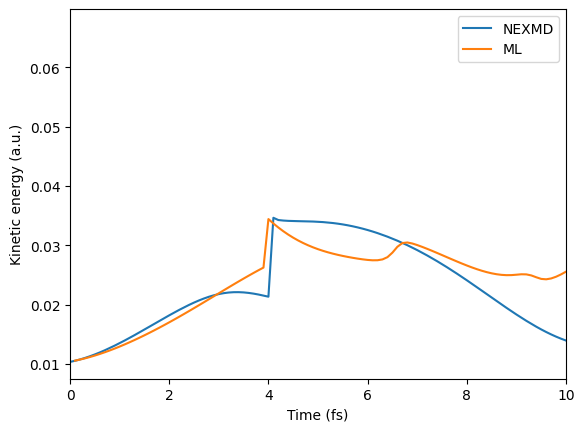

In [20]:
ek = np.genfromtxt(
    "/projects/ml4chem/xinyang/azomethane/ml/NEXMD1/test/energy-ev.out", usecols=(1)
) * eV2au
plt.xlim([0, 10])
plt.plot(time_nexmd, ek, label="NEXMD")
plt.plot(time, ekin_log, label="ML")
plt.ylabel("Kinetic energy (a.u.)")
plt.xlabel("Time (fs)")
plt.legend()

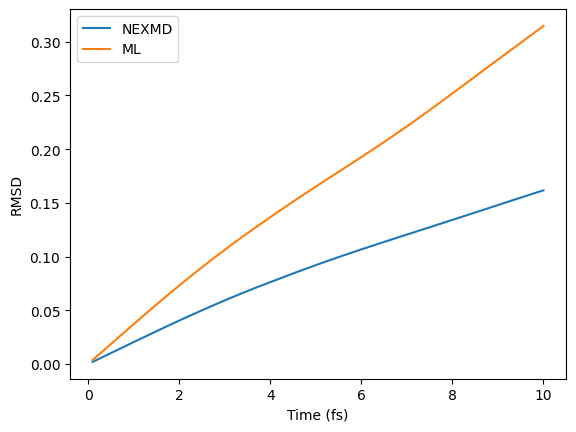

In [23]:
atoms = iread("/projects/ml4chem/xinyang/azomethane/ml/NEXMD1/test2/coords.xyz")
coords0 = next(atoms).positions
rmsd_nexmd = []
for i in atoms:
    tmp = i.positions
    tmp = math.sqrt(((tmp - coords0) ** 2).sum(axis=1).mean())
    rmsd_nexmd.append(tmp)

coords = np.array(coords_log) / A2au
coords0 = mol[0].atom_coords() / A2au
rmsd = np.sqrt(((coords - coords0) ** 2).sum(axis=1).mean(axis=1))
plt.plot(time, rmsd_nexmd, label="NEXMD")
plt.plot(time, rmsd, label="ML")
plt.ylabel("RMSD")
plt.xlabel("Time (fs)")
plt.legend()

In [12]:
symbols = mol[0].elements


def draw_molecules(Step: int = 0):
    coords = coords_log[Step]
    xyz = Atoms(symbols=symbols, positions=coords / 1.8897259886)
    view = nv.show_ase(xyz)
    return view


interact(draw_molecules, Step=IntSlider(min=0, max=len(time) - 1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='Step', max=999), Output()), _dom_classes=('widget-intera…

<function __main__.draw_molecules(Step: int = 0)>

In [76]:
a = np.empty((3, 3))
b = np.empty(3)

In [79]:
a @ b == np.matmul(a, b)

array([ True,  True,  True])

In [16]:
a = np.empty((3, 3), dtype=complex)
b = np.empty(3, dtype=complex)

In [19]:
a @ b == np.matmul(a, b)

array([ True,  True,  True])

Text(0.5, 1.0, 'BOMD $S_3$')

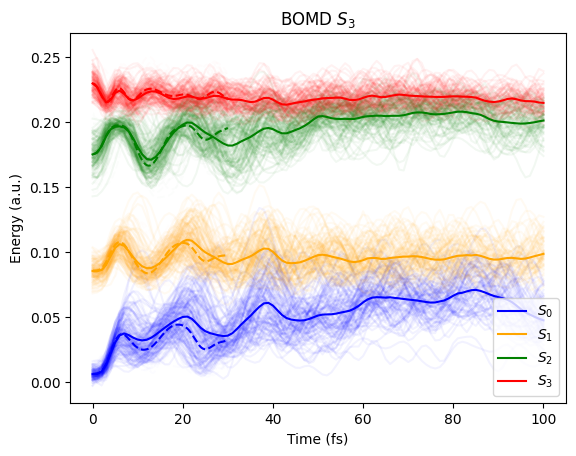

In [8]:
fig, ax = plt.subplots()
colors = ["blue", "orange", "green", "red"]
time = np.arange(1, 301) * 0.1
e0 = []
pes_ml = np.zeros((300, 4))
count = np.zeros(300)
dirs = os.listdir("test_ml/results_bomd_s3")
for i in dirs:
    dir = f"test_ml/results_bomd_s3/{i}"
    pes = np.genfromtxt(f"{dir}/epot.txt")
    total_steps = len(pes)
    for i in range(4):
        ax.plot(time, pes[:, i], c=colors[i], ls="--", alpha=0.01)
    pes_ml[:total_steps] += pes
    e0.append(pes[0, 0])
    count[:total_steps] += 1
pes_ml /= count.reshape(-1, 1)
e0 = np.array(e0)
pes_nexmd = np.zeros((101, 5))
count = np.zeros(101)
dirs = np.genfromtxt("/projects/ml4chem/xinyang/azomethane/ml/bomd/123", dtype=str)
for j, i in enumerate(dirs):
    dir = f"/projects/ml4chem/xinyang/azomethane/ml/bomd/{i}"
    pes = np.genfromtxt(f"{dir}/pes.out")
    total_steps = len(pes)
    pes[:, 1:] *= eV2au
    pes[:, 1:] -= pes[1, 1] - e0[j]
    for i in range(4):
        ax.plot(pes[:, 0], pes[:, i + 1], c=colors[i], alpha=0.05)
    pes_nexmd[:total_steps] += pes
    count[:total_steps] += 1
pes_nexmd /= count.reshape(-1, 1)
for i in range(4):
    ax.plot(time, pes_ml[:, i], c=colors[i], ls="--")
    ax.plot(pes_nexmd[:, 0], pes_nexmd[:, i + 1], c=colors[i], label=f"$S_{i}$")
ax.legend()
ax.set_xlabel("Time (fs)")
ax.set_ylabel("Energy (a.u.)")
ax.set_title("BOMD $S_3$")

FileNotFoundError: test_ml/results_bomd_s2/100/epot.txt not found.

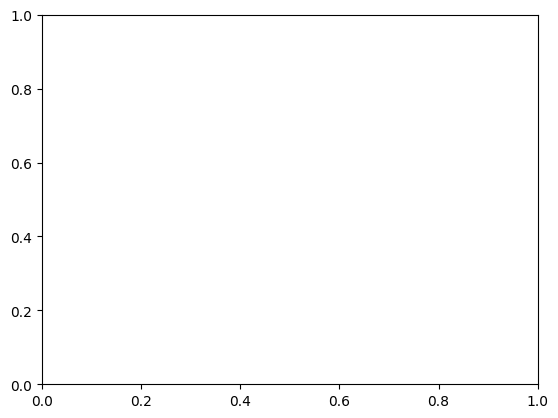

In [12]:
fig, ax = plt.subplots()
colors = ["blue", "orange", "green", "red"]
time = np.arange(1, 301) * 0.1
e0 = []
pes_ml = np.zeros((300, 4))
count = np.zeros(300)
dirs = os.listdir("test_ml/results_bomd_s2")
for i in dirs:
    dir = f"test_ml/results_bomd_s2/{i}"
    pes = np.genfromtxt(f"{dir}/epot.txt")
    total_steps = len(pes)
    for i in range(4):
        ax.plot(time, pes[:, i], c=colors[i], ls="--", alpha=0.01)
    pes_ml[:total_steps] += pes
    e0.append(pes[0, 0])
    count[:total_steps] += 1
pes_ml /= count.reshape(-1, 1)
e0 = np.array(e0)
pes_nexmd = np.zeros((101, 5))
count = np.zeros(101)
dirs = np.genfromtxt("/projects/ml4chem/xinyang/azomethane/ml/bomd/123", dtype=str)
for j, i in enumerate(dirs):
    dir = f"/projects/ml4chem/xinyang/azomethane/ml/bomd_s2/{i}"
    pes = np.genfromtxt(f"{dir}/pes.out")
    total_steps = len(pes)
    pes[:, 1:] *= eV2au
    pes[:, 1:] -= pes[1, 1] - e0[j]
    for i in range(4):
        ax.plot(pes[:, 0], pes[:, i + 1], c=colors[i], alpha=0.05)
    pes_nexmd[:total_steps] += pes
    count[:total_steps] += 1
pes_nexmd /= count.reshape(-1, 1)
for i in range(4):
    ax.plot(time, pes_ml[:, i], c=colors[i], ls="--")
    ax.plot(pes_nexmd[:, 0], pes_nexmd[:, i + 1], c=colors[i], label=f"$S_{i}$")
ax.legend()
ax.set_xlabel("Time (fs)")
ax.set_ylabel("Energy (a.u.)")
ax.set_title("BOMD $S_2$")

FileNotFoundError: test_ml/results_bomd_s1/0/epot.txt not found.

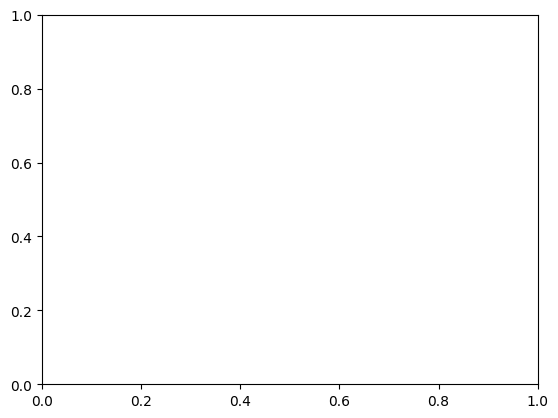

In [6]:
fig, ax = plt.subplots()
colors = ["blue", "orange", "green", "red"]
time = np.arange(1, 1001) * 0.1
e0 = []
pes_ml = np.zeros((1000, 4))
count = np.zeros(1000)
dirs = os.listdir("test_ml/results_bomd_s1")
for i in dirs:
    dir = f"test_ml/results_bomd_s1/{i}"
    pes = np.genfromtxt(f"{dir}/epot.txt")
    total_steps = len(pes)
    for i in range(4):
        ax.plot(time, pes[:, i], c=colors[i], ls="--", alpha=0.01)
    pes_ml[:total_steps] += pes
    e0.append(pes[0, 0])
    count[:total_steps] += 1
pes_ml /= count.reshape(-1, 1)
e0 = np.array(e0)
pes_nexmd = np.zeros((101, 5))
count = np.zeros(101)
dirs = np.genfromtxt("/projects/ml4chem/xinyang/azomethane/ml/bomd/123", dtype=str)
for j, i in enumerate(dirs):
    dir = f"/projects/ml4chem/xinyang/azomethane/ml/bomd_s1/{i}"
    pes = np.genfromtxt(f"{dir}/pes.out")
    total_steps = len(pes)
    pes[:, 1:] *= eV2au
    pes[:, 1:] -= pes[1, 1] - e0[j]
    for i in range(4):
        ax.plot(pes[:, 0], pes[:, i + 1], c=colors[i], alpha=0.05)
    pes_nexmd[:total_steps] += pes
    count[:total_steps] += 1
pes_nexmd /= count.reshape(-1, 1)
for i in range(4):
    ax.plot(time, pes_ml[:, i], c=colors[i], ls="--")
    ax.plot(pes_nexmd[:, 0], pes_nexmd[:, i + 1], c=colors[i], label=f"$S_{i}$")
ax.legend()
ax.set_xlabel("Time (fs)")
ax.set_ylabel("Energy (a.u.)")
ax.set_title("BOMD $S_1$")

In [47]:
class TullyModel1(QuantumDriver):
    def __init__(self, molecule, a=0.01, b=1.6, c=0.005, d=1.0, **kwargs):
        self.mol = molecule
        self.a = a
        self.b = b
        # set c to 0 to disable NAC
        self.c = c
        # set d to 0 for constant NAC
        self.d = d
        self.H = np.empty((2, 2), dtype=float)
        self.dH = np.empty((2, 2), dtype=float)
        super(**kwargs).__init__()

    def get_H(self, x):
        x = x.flatten()[0]
        if x > 0:
            e0 = self.a * (1 - np.exp(-self.b * x))
            f0 = self.a * self.b * np.exp(-self.b * x)
        else:
            e0 = self.a * (np.exp(self.b * x) - 1)
            f0 = self.a * self.b * np.exp(self.b * x)
        d = self.c * np.exp(-self.d * x**2)
        # self.H = np.array([[e0, d], [d, -e0]])
        self.H[0, 0] = e0
        self.H[0, 1] = d
        self.H[1, 0] = d
        self.H[1, 1] = -e0
        d *= -2 * self.d * x
        # self.dH = np.array([[f0, d], [d, -f0]])
        self.dH[0, 0] = f0
        self.dH[0, 1] = d
        self.dH[1, 0] = d
        self.dH[1, 1] = -f0

    def diag(self):
        e, wf = np.linalg.eig(self.H)
        idx = np.argsort(e)
        self.e = np.take_along_axis(e, idx, axis=0)
        self.wf = wf[:, idx]

    def get_energies(self, x=None):
        self._assign_energies(self.mol[0], self.e)
        return self.e[np.newaxis, :]

    def nuc_grad(self):
        f = []
        for i in range(2):
            tmp = self.wf[:, i] @ self.dH @ self.wf[:, i]
            f.append([tmp, 0, 0])
        f = -np.array(f)
        return f

    def _assign_forces(self, molecule, force):
        for i in range(len(force)):
            molecule.states[i].forces = force[i]

    def _assign_energies(self, molecule, energy):
        for i in range(len(energy)):
            molecule.states[i].energy = energy[i]

    def calculate_forces(self):
        forces = self.nuc_grad()
        self._assign_forces(self.mol[0], forces)

    def get_nact(self, veloc: np.array):
        d = self.get_nacr()[0]
        return np.array([d * veloc.flatten()[0]])

    def get_nacr(self):
        tmp = self.wf[:, 0] @ self.dH @ self.wf[:, 1]
        d = tmp / (self.e[1] - self.e[0])
        if d < 0:
            d = -d
        return np.array([d])[np.newaxis, :]